<font size=8>Reducción dimensional</font>

In [48]:
# Para que ande tanto en python 2 cuanto en python 3
from __future__ import division, print_function, unicode_literals

# Importaciones comunes
import numpy as np
import os, sys

%matplotlib inline
import matplotlib.pyplot as plt

# Para que la salida de este notebook sea la misma en distintas ejecuciones
np.random.seed(42)

# Para hacer lindas gráficas
import matplotlib as mpl
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Donde grabar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "11_Unsupervised"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignorar advertencias (warnings) inútiles (ver el SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")


# Reducción de dimensionalidad

Trabajar en espacios de gran dimensionalidad, lo que es lo mismo, trabajar con datos con muchas features o campos, es frecuentemente un inconveniente o incluso imposible. Uno puede querer **reducir la dimensionalidad** con vistas a:
* hacer visualizaciones
* ahorrar espacio ocupado por los datos (compresión)
* reducir los costos computacionales de entrenamiento de algoritmos, reduciendo el número de características
* aumentar la performance de un modelo aumentando la relación señal/ruído, así como la densidad de puntos (*evitar la maldición de la dimensionalidad*).

Al problema de reducir la dimensionalidad de las características, mientras se retiene la mayor parte de la información, se lo conoce como **reducción de la dimensionalidad** y hay dos enfoques principales para atacarlo:
* Proyección: reducir un espacio de alta dimensionalidad a un plano (o subespacio de menor dimensión), eliminando las características que no contribuyen significativamente a ese plano y que son perpendiculares a él.
* Aprendizaje de variedad (*Manifold-Learning*): aprender la geometría de una variedad de menor dimensionalidad y proyectar los datos en ella.

En la primera categoría, el algoritmo más conocido es el de Análisis de Componentes Principales (PCA).

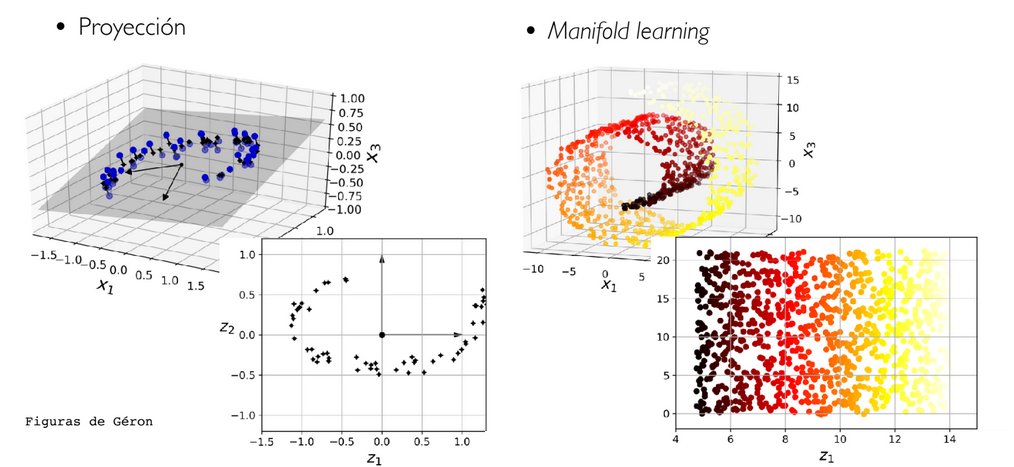

## Análisis de Componentes Principales - *Principal Component Analysis (PCA)*

El objetivo del Análisis de Componente Principales es encontrar las direcciones sobre las cuales proyectar los datos de forma a minimizar la pérdida de infromación al reducir la dimensionalidad.

Veremos eso en acción, pero antes démosle una mirada más intuitiva e ingenua al problema, a partir de un ejemplo simplificado.

### Enfoque ingenuo a la reducción dimensional


Vamos a crear un conjunto de datos fictício, de puntos en 2 dimensiones (2D) y vamos a suponer que, por alguna razón, queremos reducir los datos a una única dimensión. O sea, cada instancia de datos $x$ es representada por dos números reales, y queremos construir un conjunto aproximado de datos en un espacio unidimensional, o sea, cada nueva instancia $z$ será representada por un único número.

En principio uno podría quedarse con una sóla de las dimensiones y descartar las otras, pero en general la pérdida de información va a ser muy grande. La idea en cambio es tratar de hacer alguna combinación de las componentes de las distintas dimensiones tal que esa combinación describa razonablemente los datos.

Salvo en situaciones muy específicas, como cuando los valores de una dimensión están directamente relacionados con las otras (por ej. $x = (a, 2a)$, o sea, el segundo valor es el doble del primero), siempre vamos a perder alguna información haciendo eso. El juego es encontrar la forma de elegir ese único número que reduzca esa perdida de información.

Empecemos.

**Crear un conjunto de datos 2D a partir de una distribución normal homogénea y hacerla rotar**

Dimension del array de datos: (200, 2)


Text(0, 0.5, '$X_2 (base)$')

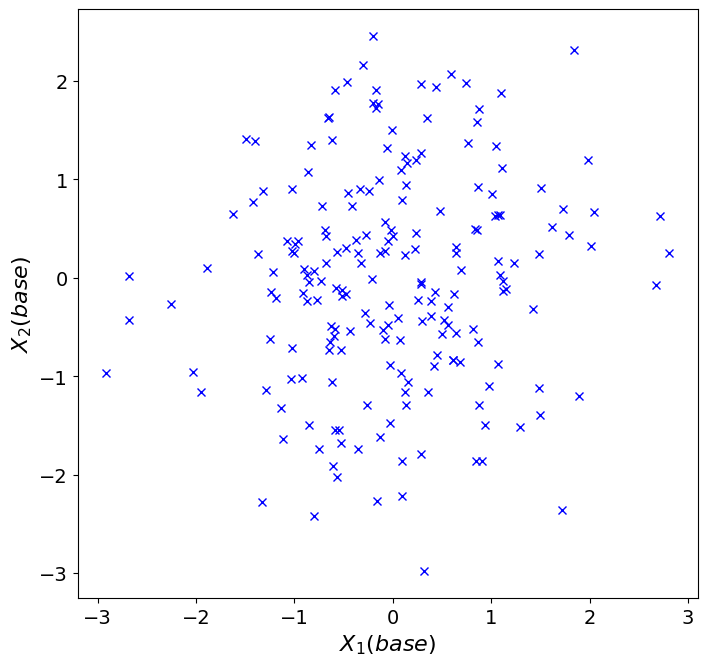

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Crear dats independientes con distribución gaussiana (200 puntos)
m = 200
np.random.seed(3)
X_base = np.random.randn(m, 2)

# Verificar la dimensión del array (matriz) resultante
print('Dimension del array de datos:', X_base.shape)

# Miremos el conjunto de datos que creamos
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_base.T, marker='x', color='b', ls='')
ax.set_aspect('equal')
ax.set_xlabel('$X_1 (base)$', fontsize=16)
ax.set_ylabel('$X_2 (base)$', fontsize=16)

In [ ]:
# Definir el angulo por el cual vamos a rotar los datos y el factor por el cual los estiraremos
angle = np.pi / 8
stretch = 5

# Matriz de estiramiento (deformación)
S = np.array([[stretch, 0],
              [0, 1]])

# Matriz de rotación
R = np.array([[np.cos(angle), np.sin(angle)],
              [-np.sin(angle), np.cos(angle)]])

# Estiramiento (usamos el operador @ de numpy para multiplicar vector * matriz)
X = X_base @ S
# Rotación
X = X @ R

Text(0, 0.5, '$X_2$')

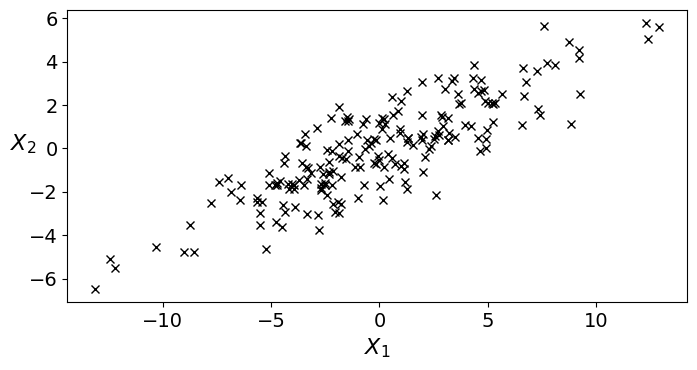

In [ ]:
# Miremos el conjunto de datos resultante
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X.T, marker='x', color='k', ls='')
ax.set_aspect('equal')
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

Evidentemente, esos son solo números aleatorios en 2D. Vamos a suponer que centramos los datos sustrayendo el promedio de cada eje (por eso los datos están centrados en 0.0).

Pueden pensar en un par de ejemplos de conjuntos de datos donde esa situación puede existir:

* altura versus peso de una muestra de personas para una dada población
* precio de algún bien versus la demanda por ese bien

**¿Pueden pensar en uno o dos ejemplos adicionales?**

Como dijimos antes, una forma de reducir la dimensionalidad de ese conjunto de datos sería simplemente **quitar una de las dimensiones**.

### Descartando una dimensión

Podemos ver los histogramas de la proyección de los datos en los ejes $x$ e $y$

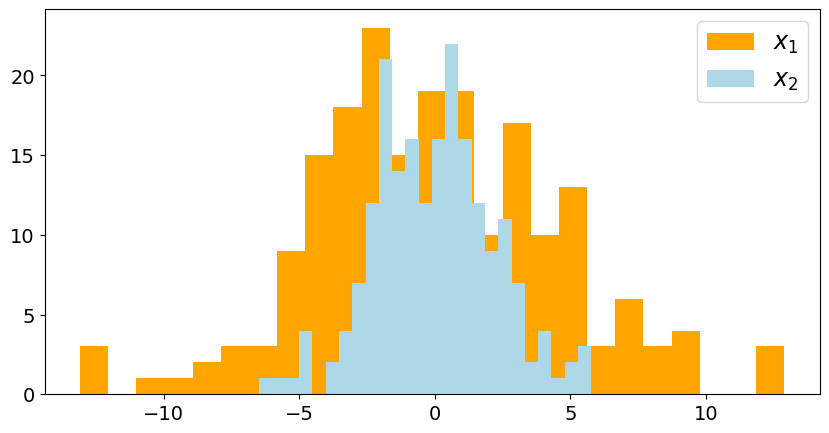

In [ ]:
ax = plt.figure(figsize=(10, 5)).add_subplot(111)

ax.hist(X[:, 0], label='$x_1$', color='orange', bins=25)
ax.hist(X[:,1], label='$x_2$', color='lightblue', bins=25)
ax.legend(loc=0, fontsize=17)


Claramente **ninguna de esas dos direcciones** es buena. Si se descartara una de estas dimensiones (por ejemplo, x1 o x2), perderías gran parte de la estructura de los datos, ya que las direcciones principales (donde los datos están más dispersos) no están alineadas con x1 o x2.

**¿Pueden imaginar las direcciones que piensan que producirían\ una mejor conservación de la información de los datos? ¿Por qué?**

### *Proyección en las diagonales

Mirando a los datos, parece tener sentido **proyectarlos en las direcciones diagonales** y quedarse con solo una de ellas. Hay dos diagonales, entonces hagamos las dos proyecciones y veamos cual funciona mejor.

In [ ]:
variant_1 = X[:, 0] + X[:, 1] # x + y
variant_2 = X[:, 0] - X[:, 1] # x - y

Text(0, 0.5, '$X_2$')

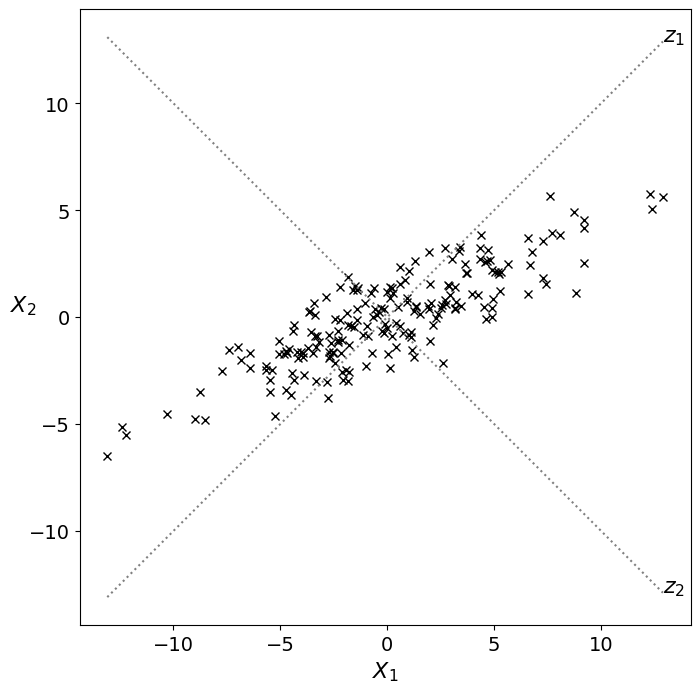

In [ ]:
# Miremos los conjuntos de datos resultantes
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

imin = np.argmin(X[:, 0])
imax = np.argmax(X[:, 0])

ax.plot([X[imin, 0], X[imax, 0]], [X[imin, 0], X[imax, 0]], ls=':', color='gray')
ax.plot([X[imin, 0], X[imax, 0]], [-X[imin, 0], -X[imax, 0]], ls=':', color='gray')

# Anotar nuevos ejes
ax.annotate('$z_1$', [X[imax, 0], X[imax, 0]], fontsize=16)
ax.annotate('$z_2$', [X[imax, 0], -X[imax, 0]], fontsize=16)

# Saque los comentários en estas dos lineas para hacer gráficas de las proyecciones
# ax.plot(0.5*variant_1, 0.5*variant_1, 'x', color='orange', ls='')
# ax.plot(0.5*variant_2, -0.5*variant_2, 'x', color='lightblue', ls='')

# Etiquetas
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

Ahora veamos como quedan los histogramas de la proyección de los datos en las diagonales ($z_1$ y $z_2$)

Text(0.5, 0, '$z$')

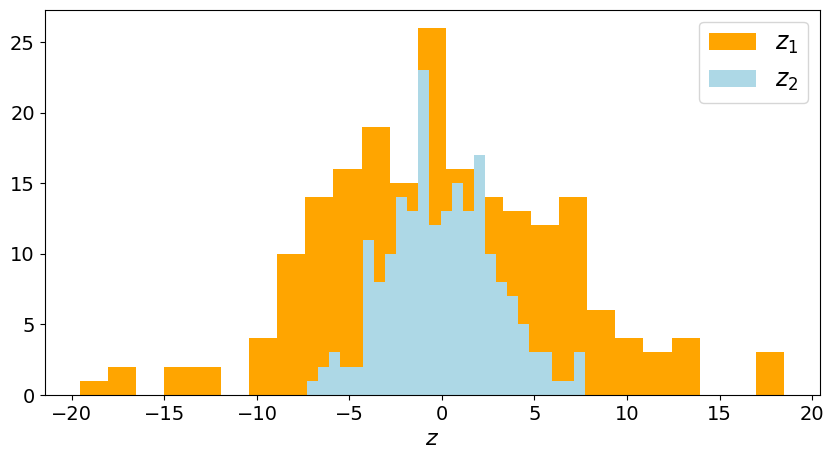

In [ ]:
ax = plt.figure(figsize=(10, 5)).add_subplot(111)

ax.hist(variant_1, label='$z_1$', color='orange', bins=25)
ax.hist(variant_2, label='$z_2$', color='lightblue', bins=25)
ax.legend(loc=0, fontsize=17)

ax.set_xlabel('$z$', fontsize=16)

Vemos que hay una dirección en que los datos tienen más dispersión que en la otra y probablemente preserve más información.
Esa sería una buena candidata para escoger como $z$.

**¿Cual de las dos opciones elegirían?**

### Ejecutando PCA

La principal finalidad del Análisis de Componentes Principales, PCA (de *Principal Component Analysis*) es encontrar el conjunto óptimo de ejes sobre los cuales proyectar los datos disponibles. Cada una de las direcciones de esos ejes es llamada de Componente Principal.

En PCA la elección de los ejes más importantes se hace según su varianza. La primera Componente Principal es la dirección que continene la mayor parte de la varianza de los datos. Otras direcciones son encontradas (tantas cuanto el número de dimensiones, o sea, características, en el conjunto de datos), con la condición de que cada componente sucesiva retenga la mayor parte posible de la varianza que queda y que sea ortogonal a todas las anteriores.

En otras palabras, el algoritmo ajusta un elipsoide a los datos y entonces rota los ejes para que estén alineados con los ejes principales del elipsoide. Los ejes rotados son las componentes principales. *(Para las personas que les gusten el álgebra lineal, esto es equivalente a encontrar una base ortogonal en la que la matriz de covarianza es diagonalizada).*

Veamos la implementación en `sklearn`.

En este caso estamos lidiando con una clase conocida como `Transformer` (no confundir con los modelos de *Deep Learning* de mismo nombre que están en voga en la actualidad). En `sklearn`, esas clases tienen un método `.fit` (ajustar) que toman un conjunto de datos como argumento y aprende algunos parámetros a partir de él. En este caso, el método aprende la matriz de covarianza a partir de los datos y como invertirla. También tienen un método `transform` (transformar) que usa los parámetros aprendidos para hacer una transformación en el conjunto de datos. En este caso, convierte el conjunto de datos original en el conjunto reducido.

Finalmente, el método `fit_transform` concatena los dos pasos.

**Es importante para hacer PCA que el conjunto de datos esté normalizado**. Para eso usaremos otro *transformer*, el `StandardScaler`.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Instanciar el escalonador y normalizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encuentra los componentes principales (¿cuántas componentes queremos?)
pca = PCA(n_components=1) # n_components: número de componentes con las que nos quedamos
X_pca = pca.fit_transform(X_scaled)

**Exploren la forma de la salida. ¿Tiene sentido?**

In [ ]:
print(X.shape, X_pca.shape)

(200, 2) (200, 1)


Las coordenadas de los ejes elegidos para proyectar (o sea, los componentes principales) son guardados en el atributo `components_` en cada línea.

In [ ]:
pca.components_.shape

(1, 2)

**Veamos esas direcciones en la gráfica de arriba**

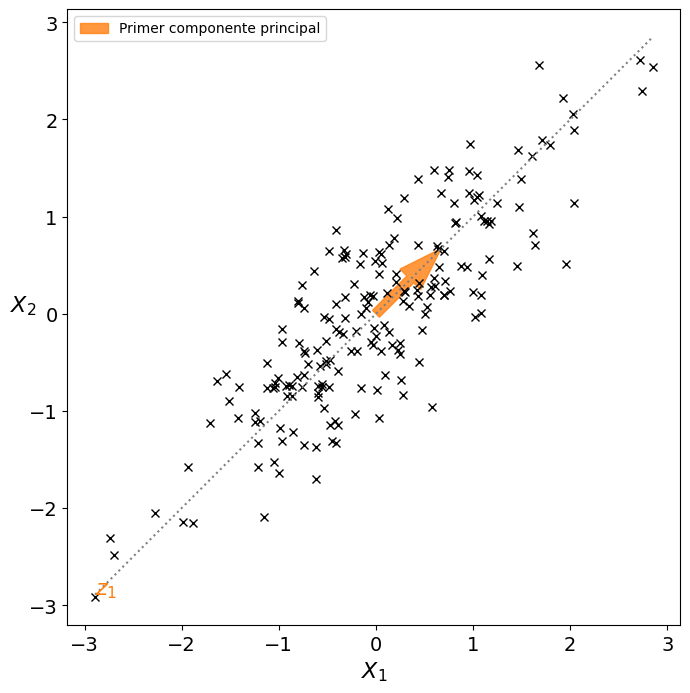

In [ ]:
# Miremos el conjunto de datos resultante
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

z = pca.components_

for i in range(len(z)):
    #
    # dirección del componente (inclinación)
    m = z[i, 0] / z[i, 1]

    # Graficar línea
    ax.plot([X_scaled[imin, 0], X_scaled[imax, 0]],
            [X_scaled[imin, 0] * m, X_scaled[imax, 0] * m],
            ls=':', color='gray')

    # Graficar flechas
    size=0.5
    ax.arrow(0, 0, z[i, 0]*size, z[i,1]*size, color='C{}'.format(i+1), width=0.1, head_width=0.3, alpha=0.8,
             label='Primer componente principal')

    # Anotar nuevos ejes
    ax.annotate('$z_{}$'.format(i+1), [X_scaled[imin, 0], X_scaled[imin, 0]*m], fontsize=16, color='C{}'.format(i+1))

# Quitar los comentários a estas líneas para graficar proyecciones en la primer Componente Principal (definir como cero en el segundo componente)
# X_pca_cut = X_pca.copy()
# X_pca_cut[:,1]=0
# X_1 = pca.inverse_transform(X_pca_cut)
# ax.plot(*X_1.T, 'x', color='orange', ls='')

# Labels
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)
ax.legend()

### *Un poquito de álgebra

Calculemos (numéricamente) la matriz de covarianza del conjunto original de datos

Ahora miremos a la matriz de covarianza de las coordenadas transformadas.

In [ ]:
# Encuentra las componentes principales (cuantas componentes queremos?)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(np.cov(X_pca.T).round(2))

[[1.86 0.  ]
 [0.   0.15]]


Noten dos cosas:
1. la matriz de covarianza es ahora diagonal
2. la mayor parte de la varianza está en la primera coordenada (PCA ordena automaticamente las características por su varianza).

### *Datos en los ejes transformados

Text(0, 0.5, '$z_2$')

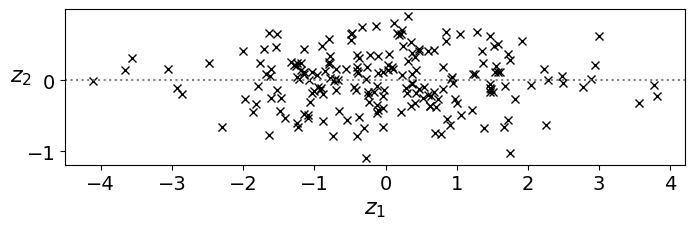

In [ ]:
# En los ejes transformados, los datos se parecen a un elipsóide alineado
ax = plt.figure(figsize=(8, 8)).add_subplot(111)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
ax.plot(*X_pca.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

ax.axhline(0.0, color='gray', ls=':')

# Nombres de los ejes
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)

**Pregunta**. Volviendo a los ejemplos de uso de arriba (altura versus peso, etc.). ¿Pueden decir qué es lo que cada nueva coordenada $z$ representa?


Podemos volver facilmente al espacio original usando el método `inverse_transform`. Note que el código chequea si la reconstrucción se ha hecho correctamente (es decir, si la reconstrucción es perfecta, o si se perdió información en el proceso).

In [ ]:
X_reconstructed = pca.inverse_transform(X_pca)

print('La reconstruccuión está perfecta? {}'.format('Sí' if np.allclose(X_scaled, X_reconstructed) else 'No'))

La reconstruccuión está perfecta? Sí


**Pregunta**. ¿Perdimos alguna información al ir al espacio de PCA y volver? ¿Hemos reducido la dimensionalidad del conjunto de datos?

### Reconstrucción incompleta

Ir al espacio PCA y volver no es una tarea de reducción de dimensionalidad y, por lo tanto, no conlleva a ninguna pérdida de información. Veamos qué ocurre si solo mantenemos la proyección de los datos en la primera componente principal.

In [ ]:
# Ejecutar PCA en un solo componente
pca = PCA(n_components=1)
X_pca_1D = pca.fit_transform(X_scaled)

Si hacemos la transformada inversa, veremos que alguna información se ha perdido, de forma que los datos invertidos no son los mismos que los originales:

In [ ]:
X_reconstructed = pca.inverse_transform(X_pca_1D)
print('La reconstrucción es perfecta? {}'.format('Sí' if np.allclose(X_scaled, X_reconstructed) else 'No'))

La reconstrucción es perfecta? No


Miremos a esos datos comprimidos:

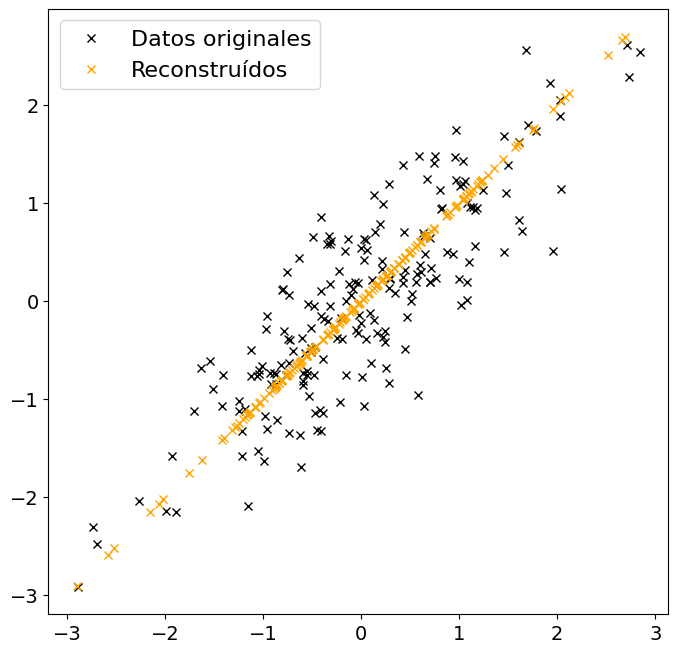

In [ ]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='', label='Datos originales')
ax.plot(*X_reconstructed.T, marker='x', color='orange', ls='', label='Reconstruídos')
ax.legend(fontsize=16)
ax.set_aspect('equal')

**Esto** es exactamente la proyección en la dirección definida por el primer componente principal. De esa forma, el conjunto resultante comprimido retiene la mayor varianza posible.

Si miramos a la matriz de covarianza, veremos que no se ha perdido mucho:

In [ ]:
print('Matriz de covarianza original\n', np.cov(X_scaled.T))
print('\nMatriz de covarianza comprimida\n', np.cov(X_reconstructed.T))

Matriz de covarianza original
 [[1.00502513 0.85070879]
 [0.85070879 1.00502513]]

Matriz de covarianza comprimida
 [[0.92786696 0.92786696]
 [0.92786696 0.92786696]]


La fracción de la varianza (información) total retenida por cada componente principal es almacenada en el atributo `explained variance_ratio_`:

In [ ]:
pca.explained_variance_ratio_

array([0.92322762])

¡Eso muestra que la proyección en la dirección de la primer componente principal retiene más de 92% de la varianza de los datos, mientras que se ha reducido la dimensión de los datos por la mitad!

### Aplicación a un conjunto de datos de gran dimensionalidad

Encontrar una representación de menor dimensión de nuestros datos nos permite guardarlos usando menos espacio y reconstruirlos permitiendo perder la menor información posible. Veamos como eso funciona con imágenes. Para eso usamos el dataset de dígitos de mnist, que son imágenes de 28x28 (784) pixeles:

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_mnist = mnist["data"]/255.0 # vean la normalización
t_mnist = mnist["target"]

Abajo les damos una función para graficar las imágenes de los dígitos del dataset:

In [ ]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [ ]:
fig =  plt.figure(figsize=(12,12))
plot_digits(X_mnist[:100], 10)

Cada dígito consiste de 784 pixeles. Veamos cómo quedan las imágenes reconstruídas cuando usamos PCA para guardarlas en un vector de menor dimensionalidad.

**Completen el código abajo con un valor razonable para el número de componentes. Recuerden que se pueden guiar cuantitativamente con el `pca.explained_variance_ratio_` que vimos antes.**

In [ ]:
pca = PCA(n_components=150)

X_reduced = pca.fit_transform(X_mnist)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
print(X_mnist.shape, X_reduced.shape, X_recovered.shape)

(70000, 784) (70000, 150) (70000, 784)


Text(0.5, 1.0, 'Comprimido')

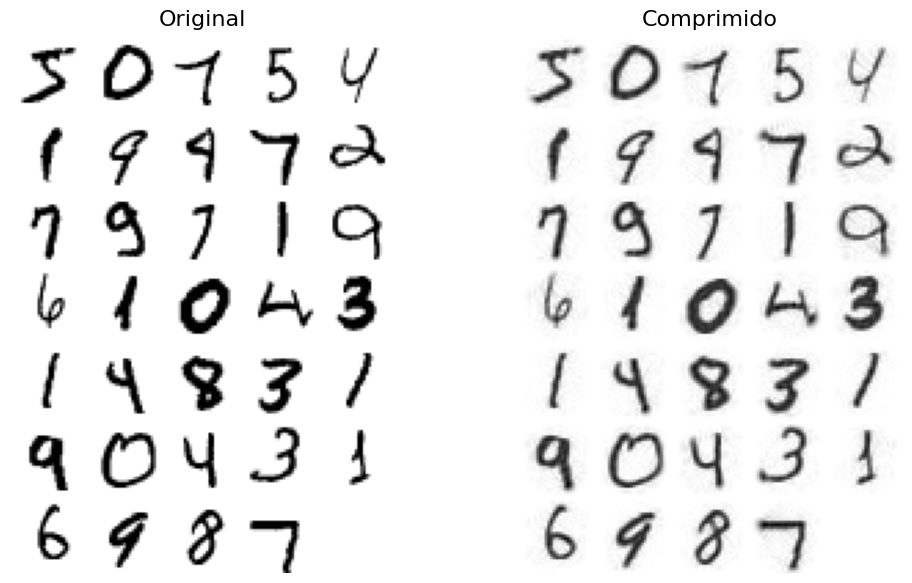

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(np.abs(X_recovered[::2100]))
plt.title("Comprimido", fontsize=16)

Si no estamos seguros sobre qué dimensionalidad deberíamos imponer, tal como les indicamos antes, podemos hacer una gráfica de la suma cumulativa de la razón de la varianza explicada para ver cuanta información se pierde. Si todas las características son usadas, la suma tendría que ser 1.

In [ ]:
pca = PCA()
pca.fit(X_mnist) #fiteo sin reducir la dimensionalidad

PCA()

In [ ]:
# Ver los primeros elementos de la variancia explicada
print(pca.explained_variance_ratio_[:10])

[0.09746116 0.07155445 0.06149531 0.05403385 0.04888934 0.04305227
 0.03278262 0.02889642 0.02758364 0.0234214 ]


**Pregunta**. Compare y contraste con las clases arriba (el conjunto de datos Iris y el conjunto de datos simulado). ¿Qué puede notar?

Es interesante obtener el número de componentes que necesitamos mantener para preservar un dado nivel de la varianza. Por ejemplo, 95%. Para eso, podemos calcular la *suma cumulativa* de las razones de la varianza explicada.

Con 154 componentes, preservamos el 0.95 de la varianza.


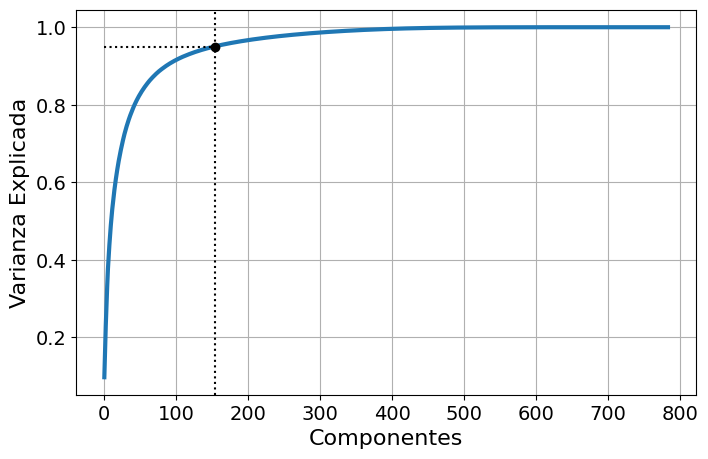

In [ ]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma cumulativa y hacer su gráfica
cumsum = np.cumsum(pca.explained_variance_ratio_)
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} componentes, preservamos el {} de la varianza.'.format(d, var_frac))

plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])

plt.axvline(d, color="k", ls=":")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.xlabel("Componentes", fontsize=16)
plt.ylabel("Varianza Explicada", fontsize=16)

plt.grid(True)

### *Visualizando las Componentes Principales

A pesar de que la tarea con la cual estamos lidiando ahora es la reducción de dimensionalidad, las direcciones dadas por los componentes principales también se pueden pensar como instancias individuales en el espacio de los datos, que corresponde cada una a una imágen de 28 x 28 pixeles.

Nos podemos preguntar cómo se ven los primeros componentes principales para este conjunto de datos.

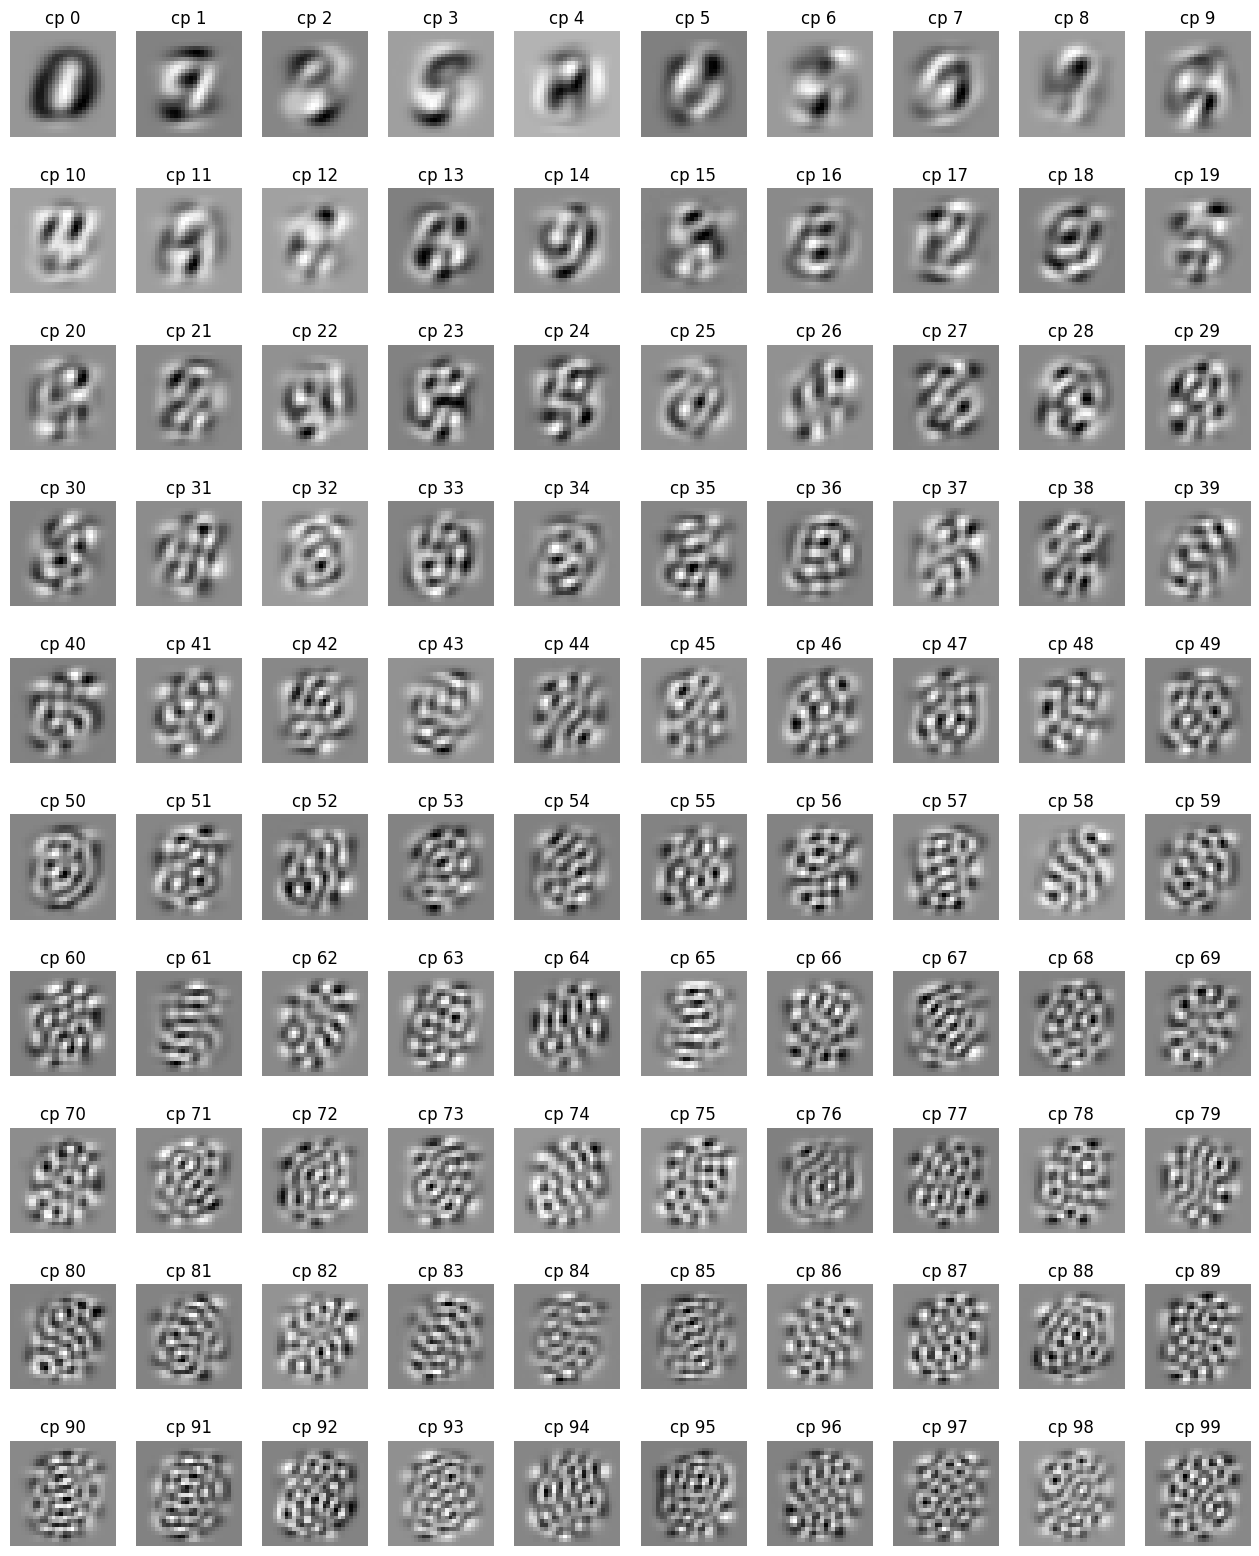

In [ ]:
npc = 100

ncolumns = 10
nrows = npc // ncolumns

# Agregar una línear extra, si se necesita
if npc % ncolumns:
    nrows += 1

fig, axs = plt.subplots(nrows, ncolumns, figsize=(16, 2*nrows))

for i, ax in zip(range(npc), axs.flatten()):
    pci_reshaped = pca.components_[i].reshape(28,28)
    ax.imshow(pci_reshaped, cmap='gray_r')
    ax.set_title(f'cp {i}')
    ax.axis('off')

**Pregunta.** ¿Pueden notar algo que valga le pena mencionar a partir de esas figuras?

Noten como el tipo de imagen cambia cuando nos movemos de las primeras pocas CP hacia las de órdenes más altas. ¿Qué creen que significa eso?

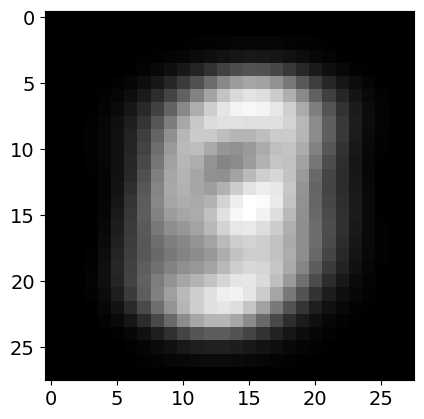

In [ ]:
# Podemos hacer una gráfica del promedio
plt.imshow(pca.mean_.reshape(28, 28), cmap='gray')

## Aprendizaje de la Variedad (_Manifold Learning_)

El aprendizaje de variedades se usa para descubrir patrones no-lineales en los datos.

Para explorar eso, vamos a usar el conjunto de datos _pionono_ (en inglés _Swiss roll_).

In [ ]:
from sklearn.datasets import make_swiss_roll

X_sr, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Esta función nos devuelve en `X_sr` las coordenadas de los puntos y en `z` una posición unidimensional de la dimensión principal del manifold. Ahora vamos a graficar los puntos `X_sr` pintándolos de acuerdo con la valor de variable `z` para entenderlo mejor. Este conjunto de datos es un plano enrollado, que es más complicado *descomponer*

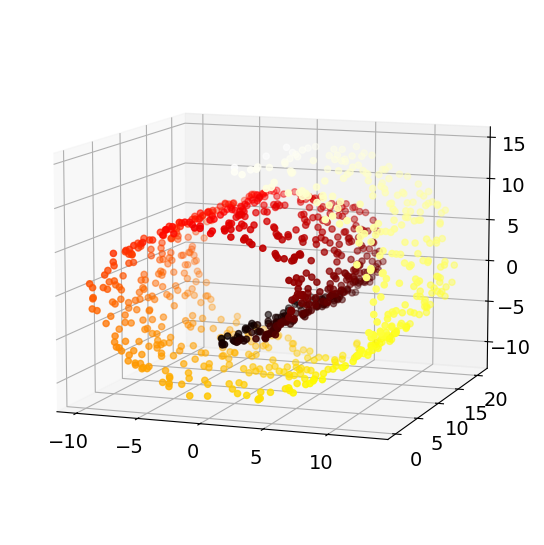

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X_sr[:, 0], X_sr[:, 1], X_sr[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Evidentemente, la proyección óptima para el pionono sería algo que _desenrolla_ los datos. Como estos datos los armamos a mano, podemos desenrollarlo perfectamente, pero esto no va a pasar en general con otros conjuntos de datos. Si ponemos `z` en el eje x y una de las otras componentes en el eje y:

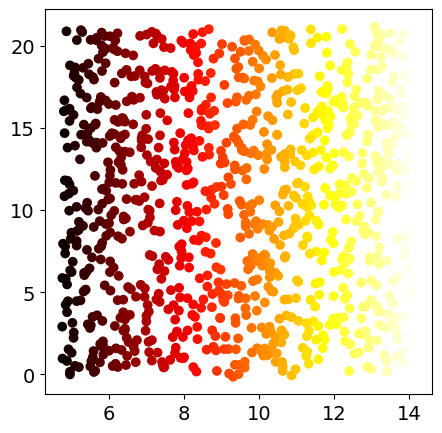

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(z, X_sr[:,1], c=z,  cmap=plt.cm.hot)

Aprender ese tipo de subespacios, que están inmersos en un espacio de mayor dimensionalidad se llama *aprendizaje de varieadades* (*Manifold Learning*).

### *Local Linear Embedding

Un método simple, que no cubriremos en detalles es el de *Inmersión Localmente Lineal* (*Locally Linear Embedding*, LLE).

LLE funciona ajustando un hiperplano en `n_components` dimensiones a los `n_neighbors` puntos de cada instancia. Después proyecta los datos a esos subespacios fiteados. Veamos como funciona con el pionono.

Como siempre, instanciamos el objeto con algunos hiperparámetros y usamos el método `fit_transform`

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X_sr)

In [ ]:
# Verificar las dimensiones de lo que hemos encontrado
print(X_sr.shape, X_reduced.shape)

(1000, 3) (1000, 2)


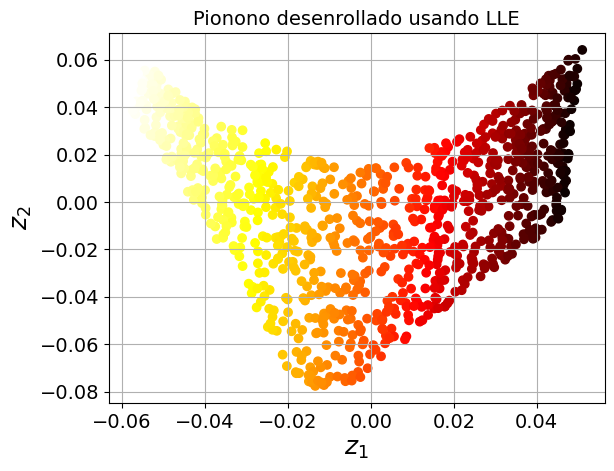

In [ ]:
# Hacer una gráfica de los resultados
plt.title("Pionono desenrollado usando LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

**No** está mal, pero tampoco es óptimo.

**Tarea**. Experimentar con el hyperparámetros `n_neighbors`. ¿Quieren resultados mejores? Navegue por la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) y vea si consigue encontrar algo más para ajustar.

### tSNE

Una técnica popular de aprendizaje de variedades usada para visualizaciones es el de *Inmersión de vecinos estocástica t-distribuída* (*t-Distributed Stochastic Neighbor Embedding*,  tSNE). Esa técnica aprende un mapeo no lineal que tiende a agrupar instancias similares, mientras separa instancias disimilares.

Vamos a probarla en el conjunto de datos MNIST. ¡Vean que simple es usarlo! Como siempre, se crea una instancia, se usa `fit_transform` y ¡a disfrutar!

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_mnist[:1000]) #fitea sólo los primeros 1000 datos para disminuir el tiempo de cómputo

In [ ]:
t_mnist.shape

(70000,)

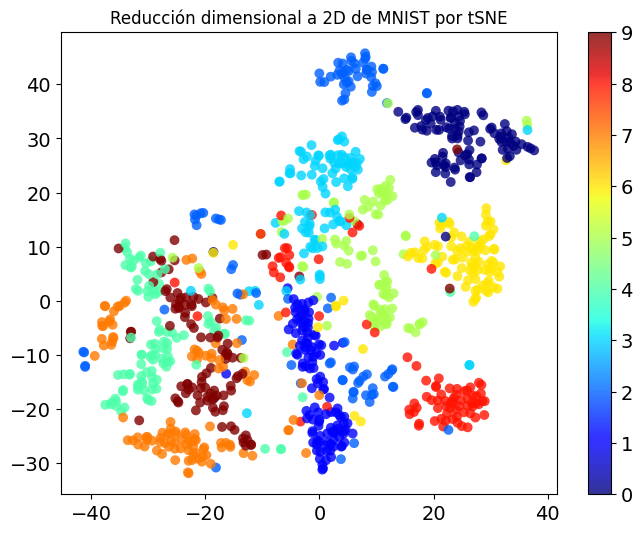

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Reducción dimensional a 2D de MNIST por tSNE')
scat = ax.scatter(*X_reduced_tsne.T, c=t_mnist[:1000], s=50, cmap='jet',
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat)

Los números se han agrupado en algunos casos, aunque el algoritmo sea totalmente ignorante de los dígitos reales asociados a cada dato (que han sido usados para colorear los puntos). ¡Increíble!

Para apreciar un poco más esto, comparemos con usar PCA quedándonos sólo con las 2 componentes más importantes:

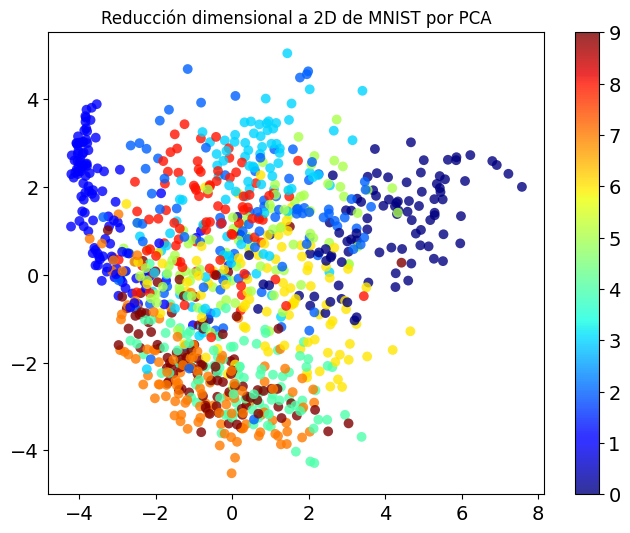

In [ ]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_mnist[:1000])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Reducción dimensional a 2D de MNIST por PCA')
scat = ax.scatter(*X_2d.T, c=t_mnist[:1000], s=50, cmap='jet',
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat)

Ahora, para terminar, intentemos hacer tSNE a 3D

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne_3d = tsne.fit_transform(X_mnist[:1000])#fit a subset to reduce computing time

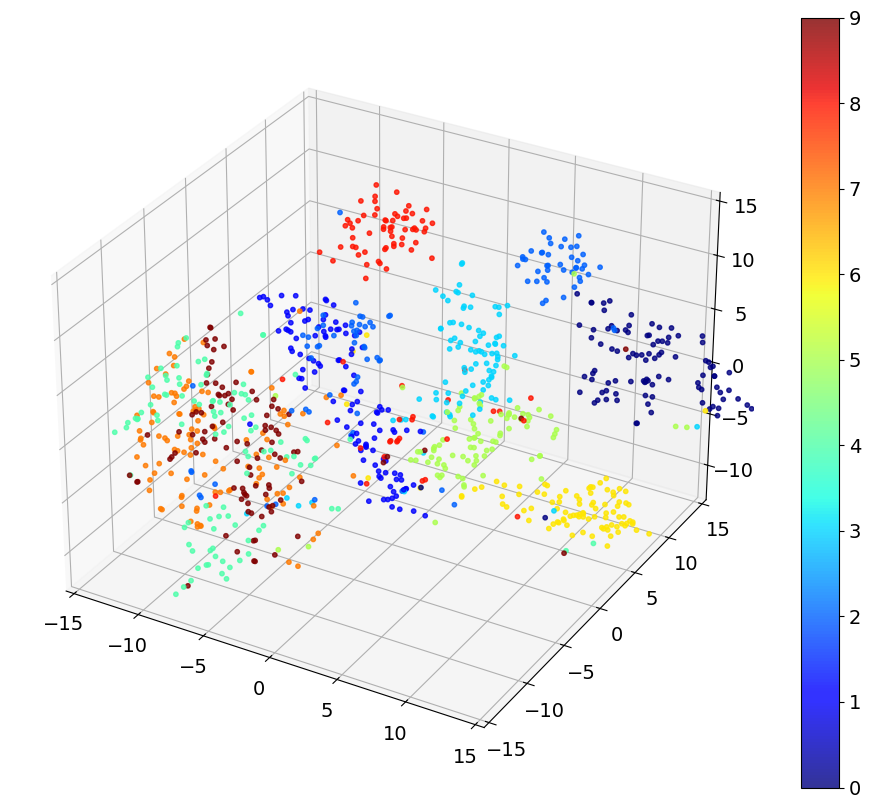

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(*X_reduced_tsne_3d.T, c=t_mnist[:1000], s=10, cmap='jet',
                   alpha=0.8)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
fig.colorbar(scat)

## *Extra: Kernel PCA

Una variante del PCA que se usa para aprender mapeos no-lineales es el llamado *kernel-PCA*, que usa el *truco del kernel* para hacer un mapeo de las características originales en un espacio de dimensionalidad mayor (quizás dimensionalidad infinita), en el cual el PCA se aplica. Eso es útil para aprender transformaciones no-lineales.

El método de Kernel PCA tiene la **gran** desventaja de que la transformación inversa no es fácil de obtener. Los invitamos a explorar este algoritmo y experimentar con sus distintos hyperparámetros:

* n_components
* kernel. Elegir cual _kernel_ usar para hacer el mapeo a un espacio de dimensionalidad más grande. Pueden intentar: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’}
* gamma. Escala de tamaño para el _kernel_ 'rbf'
* degree. Grado del polinómio para el _kernel_ 'poly'

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)

### Conjunto de datos Iris

In [ ]:
X_kpca = rbf_pca.fit_transform(X)

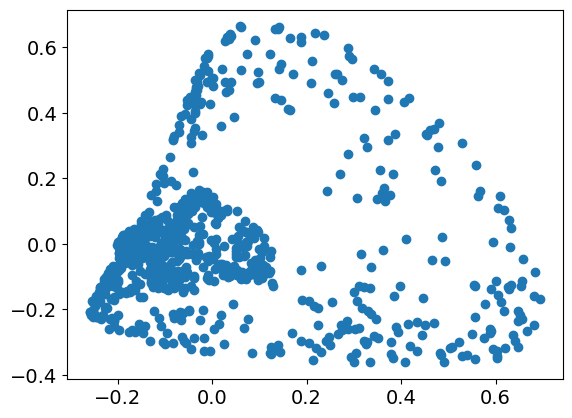

In [ ]:
plt.scatter(*X_kpca.T)

Veamos como eso se comporta con un conjunto de datos más complejos:

### El pionono (_Swiss Roll_)

In [ ]:
from sklearn.datasets import make_swiss_roll

X, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Este conjunto de datos es un plano enrollado, que es más complicado *decomponer*

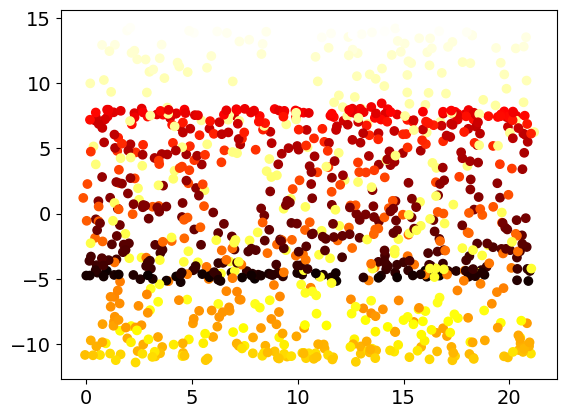

In [ ]:
plt.scatter(X[:, 1], X[:, 2], c=z,  cmap=plt.cm.hot)

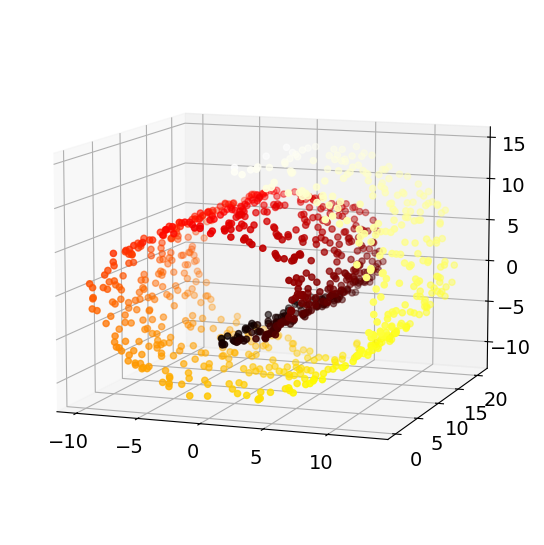

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Comparemos los resultados de distintos _kernels_

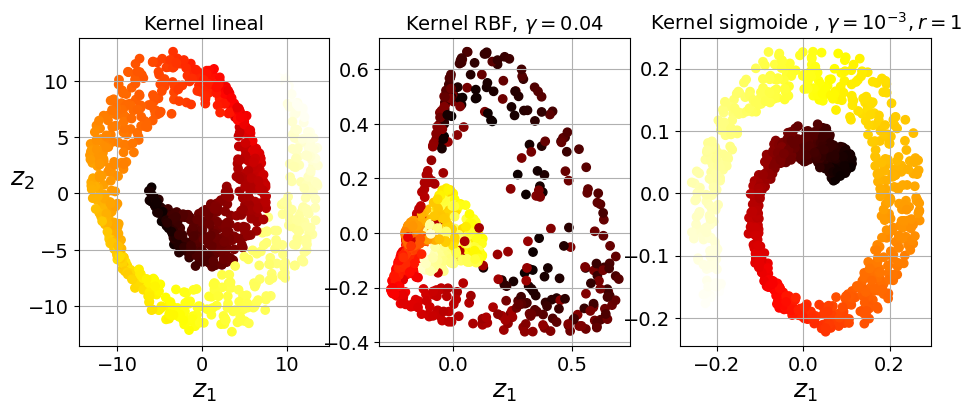

In [ ]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) #equivalente a PCA(n_components=2)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Kernel lineal"),
                            (132, rbf_pca, "Kernel RBF, $\gamma=0.04$"),
                            (133, sig_pca, "Kernel sigmoide , $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# **Clustering | Agrupamiento de datos**

El *clustering* es un conjunto de técnicas y métodos de aprendizaje no supervisado. Nos ayuda a *clasificar* o particionar en grupos (*clusters*) a un conjunto de datos.

Al igual que con las técnicas que vimos de reducción de dimensionalidad, decimos que es *no supervisado* porque no tenemos nuestros datos previamente etiquetados. Estos algoritmos buscan posibles agrupaciones de los datos y/o patrones ocultos sin necesidad alguna de intervención humana.

Luego de particionar a los datos en *grupos* la idea es que las observaciones (datos) dentro de un mismo grupo sean más similares entre sí, mientras que las observaciones (datos) de diferentes grupos sean muy diferentes entre ellas.  

Esto es extremadamente útil en una serie de escenarios:

* Para la segmentación de clientes
* Para el análisis exploratorio de datos
* Como técnica de reducción de la dimensionalidad
* Para la detección de anomalías (también llamada detección de *outliers*)
* Para el aprendizaje semi-supervisado
* Para los motores de búsqueda
* Para segmentar una imagen

## K-means

K-means es uno de los métodos mas populares (y rápidos!). Es un  algoritmo de agrupamiento (clustering) particional. Esto quiere decir que como resultado vamos a obtener *particiones* de los datos. Estos son nuestros *grupos* tambien llamados *clusters*.

K-means es simple, y elegante. Busca particionar o repartir los datos en *k* grupos no solapados (o disjuntos, esto quiere decir que un dato no puede pertenecer a más de un grupo o cluster).

Para ejecutar K-means tenemos que especificar el número `k`, y el algoritmo va a asignar los datos exactamente a cada uno de estos `k` grupos.

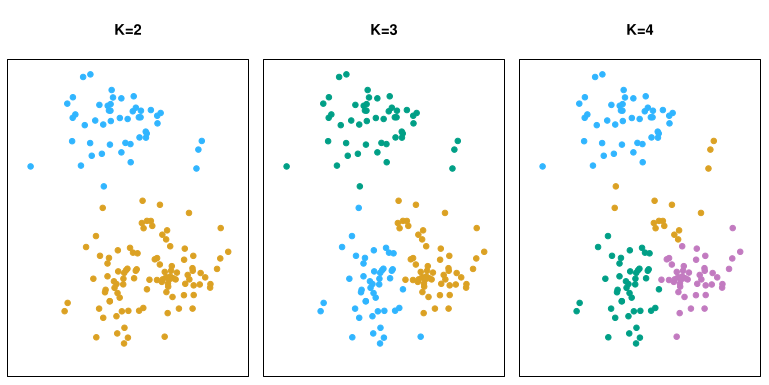

Datos simulados, agrupados mediante el algoritmo k-means con diferentes valores de *k*. Los clusters (grupos) están coloreados arbitrariamente. Figura tomada de: [Introduction to Statistical Learning, 2nd Edition](https://www.statlearning.com/)

### Fundamento del método

Para particionar los datos en `k` *grupos* la idea es que las observaciones (datos) dentro de un mismo grupo sean más similares entre sí, mientras que las observaciones (datos) de diferentes grupos sean muy diferentes entre ellas.  

Como se hace? Vamos a ilustrarlo primero paso a paso:

1) Nuestros datos, sin agrupar

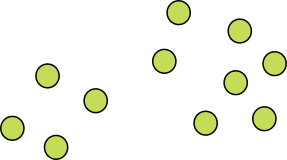

2) Para `k=2` el algoritmo K-means genera 2 observaciones (datos) al azar. Estos son nuestros *centroides*

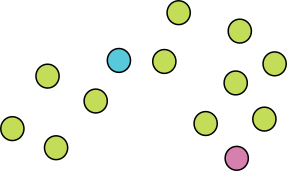

3) K-means calcula las *distancias* entre cada dato hacia cada centroide. Si un dato está más cerca del centroide *celeste*, se asigna a ese grupo. Si está más cerca del centroide *rosa* se asigna a ese otro grupo.

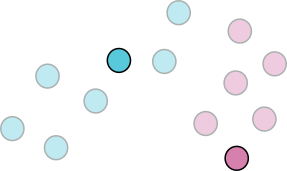

4) K-means mueve el centroide de cada grupo al centro geométrico del grupo.

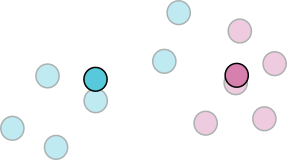

5) K-means re-calcula las distancias de cada dato a cada centroide. Si un dato está mas cerca del centroide *celeste* queda dentro del grupo celeste. Si el dato está más cerca de otro centroide, se agrupa en ese otro grupo.

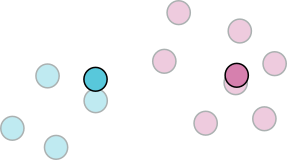


6) K-means vuelve a iterar los pasos 4 y 5 hasta convergencia (no hay más reasignación de datos a grupos).

En los pasos 3 y 5 (asignación de datos a clusters) K-means usa la *distancia* de cada dato a cada centroide. Pero cómo se mide esa distancia?

Una manera de medir distancias es usar la distancia Euclidea (geométrica), que mide la distancia en X y en Y entre dos puntos:

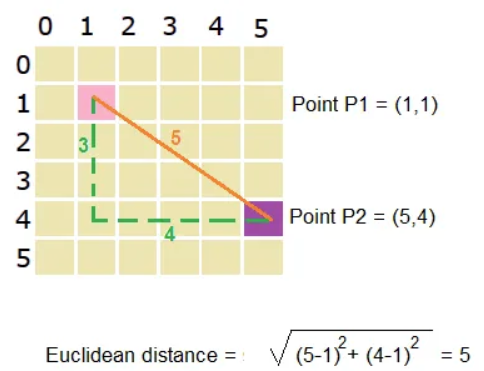

### Demo interactivo

Web demo: http://alekseynp.com/viz/k-means.html

Esto es solamente para *visualizar* o ver como funciona el algoritmo. No tiene código para ejecutar.

# K-means con Python (sklearn)

Ahora vamos a ver como hacer clustering con K-means en Python. Para eso vamos a usar el módulo SciKit Learn (`sklearn`) y dentro de este módulo, en particular vamos a usar la función  `cluster.KMeans()`

Referencias:
 - [Scikit Learn: Machine Learning in Python](https://scikit-learn.org/stable/index.html)
 - [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)


## Datos

Para empezar, vamos a generarnos un conjunto de datos, con los que vamos a trabajar. Los vamos a generar *al azar* usando `numpy.random` y en particular los vamos a generar usando la función `standard_normal()` que hace un muestreo sobre una distribución normal (gaussiana) centrada en cero (0) y con una desviación estandar de uno (1).

[numpy.random.standard_normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_normal.html)

In [1]:
import numpy as np

np.random.seed(0) # para poder reproducir el ejemplo siempre igual

datos = np.random.standard_normal((50,2)) # 50 valores * 2 dimensiones (variables, columnas)
print(datos.shape)

# nuestro conjunto de datos tiene 50 observaciones (datos = filas)
# cada fila (dato) tiene dos valores (x = 1er columna, y = 2da columna)
print(datos)

(50, 2)
[[ 1.76405235  0.40015721]
 [ 0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721]
 [-0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]
 [-2.55298982  0.6536186 ]
 [ 0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567]
 [ 0.04575852 -0.18718385]
 [ 1.53277921  1.46935877]
 [ 0.15494743  0.37816252]
 [-0.88778575 -1.98079647]
 [-0.34791215  0.15634897]
 [ 1.23029068  1.20237985]
 [-0.38732682 -0.30230275]
 [-1.04855297 -1.42001794]
 [-1.70627019  1.9507754 ]
 [-0.50965218 -0.4380743 ]
 [-1.25279536  0.77749036]
 [-1.61389785 -0.21274028]
 [-0.89546656  0.3869025 ]
 [-0.51080514 -1.18063218]
 [-0.02818223  0.42833187]
 [ 0.06651722  0.3024719 ]
 [-0.63432209 -0.36274117]
 [-0.67246045 -0.35955316]
 [-0.81314628 -1.7262826 ]
 [ 0.17742614 -0.40178094]
 [-1.63019835  0.46278226]
 [-0.90729836  0.0519454 ]
 [ 0.72909056  0.12898291]
 [ 1.13940068 -1.234

Veamos los datos: podemos graficarlos, como histograma o como una nube de puntos. El histograma nos muestra la distribución de valores de las dos columnas (x e y). El grafico de puntos (scatter plot) nos muestra la ubicación en dos dimensiones de cada uno de los 50 datos (observaciones).

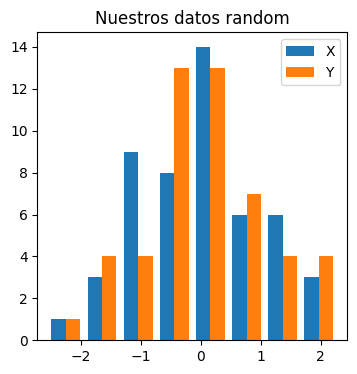

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.hist(datos, bins=8)
ax.set_title("Nuestros datos random")
ax.legend(["X", "Y"])

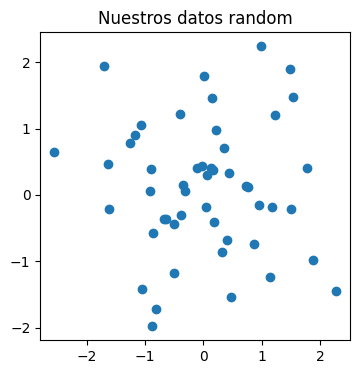

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.scatter(datos[:,0], datos[:,1]) # primer columna = x; segunda columna = y
ax.set_title("Nuestros datos random");

Ahora vamos a hacer un pequeño truco para forzar corrimientos en los datos. Vamos a hacer que las primeras 25 observaciones (datos) tengan un corrimiento de la media respecto a las ultimas 25 observaciones.

In [4]:
# a las primeras 25 filas de x le sumamos 3
datos[:25,0] += 3

# a las primeras 25 filas de y le restamos 4
datos[:25,1] -= 4

Esto lo hacemos para intentar generar grupos de datos mas o menos bien separados. Veamos que hicimos...

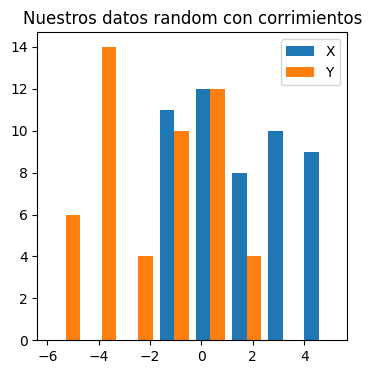

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.hist(datos, bins=8)
ax.set_title("Nuestros datos random con corrimientos")
ax.legend(["X", "Y"])

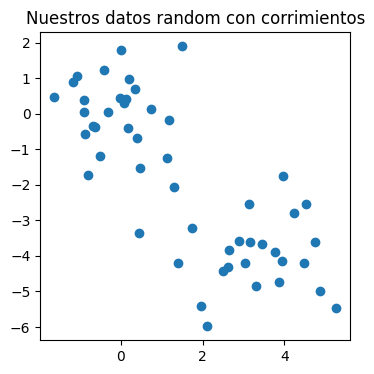

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.scatter(datos[:,0], datos[:,1]) # primer columna = x; segunda columna = y
ax.set_title("Nuestros datos random con corrimientos");

Todo esto fue preparatorio, lo único que hicimos hasta acá fue generar un set de datos aleatorio (completamente inventado, generado en la computadora) para poder trabajar y aprender técnicas de agrupamiento.

El paso a paso les queda para revisarlo y para que puedan *ver* exactamente qué fue lo que hicimos.

## Agrupando datos con K-means

Ahora si, vamos a usar `sklearn.cluster.kmeans()` sobre nuestros datos. Recordar que nuestro array de datos tiene 50 observaciones (datos), cada uno de los cuales consta de dos valores (x,y).  

In [7]:
from sklearn.cluster import KMeans

# numero de clusters
k = 3

# usamos la funcion .fit() de KMeans
agrupamientos = KMeans(n_clusters = k, random_state = 2, n_init = 20).fit(datos)

# random state es para que todos obtengamos siempre los mismos resultados
# solo tiene sentido pedagogicamente!

# n_init es el numero de veces que corremos k-means
# en cada iteración se comienza con nuevos centroides!

In [8]:
# las etiquetas (labels) contienen las particiones / clusters
# si, sklearn usa underscores al final de labels (labels_)
print(agrupamientos.labels_)

# verificar que tenemos el numero de asignaciones a clusters para todos los datos
print(agrupamientos.labels_.shape)

[1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
(50,)


El método K-means agrupó las observaciones (datos) en dos clusters, aun cuando no le dimos ninguna información adicional sobre los grupos (solamente los valores x + y). Podemos graficar los datos nuevamente, ahora usando las etiquetas (`kmeans.labels_`) para colorear las asignaciones de cada according to its cluster assignment.

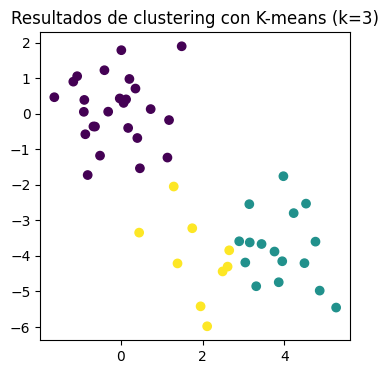

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.scatter(datos[:,0], datos[:,1], c=agrupamientos.labels_)
ax.set_title("Resultados de clustering con K-means (k=3)");

## K-means en casos más complejos

En este caso nosotros **sabíamos** de antemano que había dos clusters. Porque a partir de un muestreo aleatorio (nube de puntos en 2D sin estructura aparente), al hacer un corrimiento de la mitad de los datos hacia la derecha (x + 3) y hacia abajo (y - 4), *forzamos* que las dos mitades se separen en este espacio 2D.

En casos reales, normalmente desconocemos el número verdadero de grupos en los datos, ni sabemos si existe un número preciso de grupos. En estos casos, es usual correr K-means con distintos valores de `k`. Y luego evaluar el que mejor funciona.

Pero cómo evaluamos esto? Vamos a verlo con un ejemplo más complejo.

In [10]:
from sklearn.datasets import make_blobs

x, y = make_blobs(
    n_samples = 500,
    n_features = 2, # x, y
    centers = 4,
    cluster_std = 1,
    center_box = (-10.0, 10.0),
    shuffle = True,
    random_state = 1, # para poder reproducir el ejemplo!
)

Estos parámetros generan un cluster bien distintivo y 3 clusters posicionados bastante juntos entre sí.

In [11]:
x.shape

(500, 2)

In [12]:
def plot_clusters(x, y=None):
    plt.scatter(x[:, 0], x[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14)

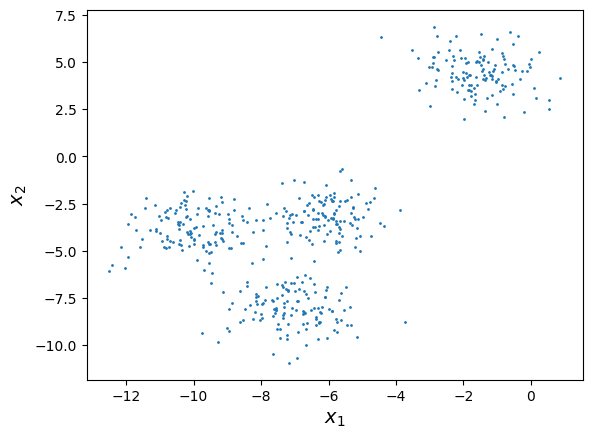

In [14]:
plot_clusters(x)

Ahora hagamos agrupamientos usando K-means

In [15]:
from sklearn.cluster import KMeans

# Hay que fijar de antemano el número de clusters que usaremos.
k = 4
kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10).fit(x)

Las etiquetas asignadas a cada dato quedan guardadas en el atributo labels_. El resultado es un array de numpy, podemos manipularlo como ya sabemos:

In [16]:
clusters = kmeans.labels_
print(type(clusters))
print(clusters.shape)
print(np.unique(clusters))

<class 'numpy.ndarray'>
(500,)
[0 1 2 3]


También podemos recuperar los centros de los clusters (centroides) con el atributo clusters_centers_. Cada centro de clúster tiene dos coordenadas (en este ejemplo!)

In [17]:
print('Coordendas de los centros de los clusters:')
print(kmeans.cluster_centers_)

Coordendas de los centros de los clusters:
[[ -7.09306648  -8.10994454]
 [ -1.54234022   4.43517599]
 [ -6.09890728  -3.18568743]
 [-10.02661816  -3.84243658]]


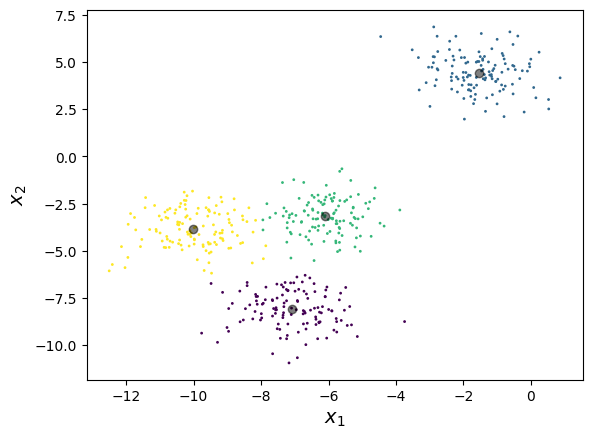

In [18]:
# podemos plotear los clusters con sus centroides!
plot_clusters(x, kmeans.labels_)

centroides = kmeans.cluster_centers_
plt.scatter(centroides[:,0], centroides[:,1], c='black', alpha=0.5)

## Fronteras de decisión

Las fronteras de decisión (decision boundaries) son posiciones en el espacio en las cuales el algoritmo no puede resolver el agrupamiento (un dato en esa posición es *equidistante* a dos centroides).

Las fronteras de decisión permiten también visualizar los agrupamientos como *mapas* de particiones en el espacio. Esto nos permite **ver** a qué partición o grupo pertenecerían datos que no vimos o conocemos todavía.

No vamos a entrar en detalles sobre como calcular estas fronteras de decisión, pero sepan que en el caso de Kmeans y otros algoritmos, estos son cálculos simples que pueden hacerse en forma genérica (les dejamos código escrito más abajo &ndash; oculto) y una referencia por si quieren leer más: [Easily visualize Scikit-learn models’ decision boundaries.](https://towardsdatascience.com/easily-visualize-scikit-learn-models-decision-boundaries-dd0fb3747508)

Código para graficar fronteras de decisión



In [19]:
#@title Código para graficar fronteras de decisión
def plot_data(x, marker='.', color='k', ls='', markersize=2, **kwargs):
    plt.plot(x[:, 0], x[:, 1], marker=marker, ls=ls, color=color, markersize=markersize, **kwargs)

def plot_centroids(centroids, weights=None, circle_color='r', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], s=35, linewidths=8, color=circle_color, zorder=10, alpha=0.5)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, markersize=2)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14)
    else:
        plt.tick_params(labelleft=False)

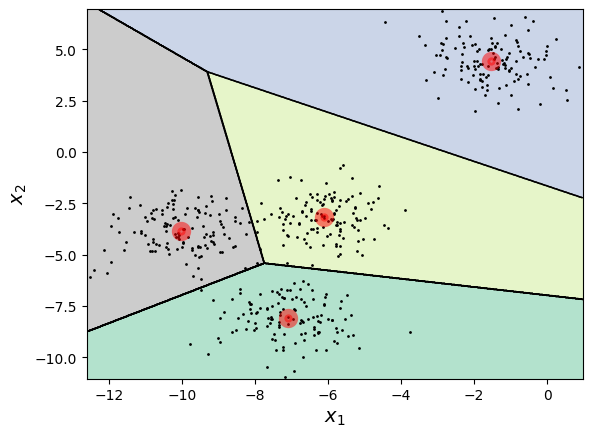

In [20]:
plot_decision_boundaries(kmeans, x)

Al igual que para calcular las fronteras de decisión, podemos calcular la distancia de cualquier dato u observación (puede ser un dato nuevo!) a los centroides finales de cada cluster. La distancia de cada dato al centro de cada clúster puede calcularse utilizando el método `transform` de `KMeans`.

In [21]:
nuevos_datos = np.array([[-1.2, 2.2], [-10,0]]) # los valores X, Y de nuevas observaciones
print(kmeans.transform(nuevos_datos))

[[11.87531848  2.26124049  7.2804479  10.69673913]
 [ 8.61518792  9.55001545  5.03657908  3.84252878]]


Conocer la distancia a los distintos centroides es una manera de aproximarnos a saber a qué cluster pertenece un dato (o con qué cluster tiene más *afinidad*).

Para saberlo más directamente, podemos usar la función `predict()` de `KMeans`. Predict, nos da la asignación de nuevos datos a los grupos (usa las mismas etiquetas de grupos que ya vimos &ndash; `labels_`.)

In [23]:
print(kmeans.predict(nuevos_datos))

[1 3]


Otra información que podemos pedirle a `sklearn.KMeans`: podemos ver cuántas interacciones necesitó el algoritmo para converger.

In [24]:
kmeans.n_iter_

3

Como pueden imaginarse, el algoritmo puede dar diferentes resultados (aun con los mismos datos!), ya que depende de dónde se inicializan los centroides en el primer paso del algoritmo.

**Ejercicio**. Cambien el valor del parámetro `random_state` por cualquier número entero y vean la diferencia en el resultado. Prueben varias veces para ver distintas opciones. En cuántas iteraciones converge en cada caso?

Iteraciones: 3


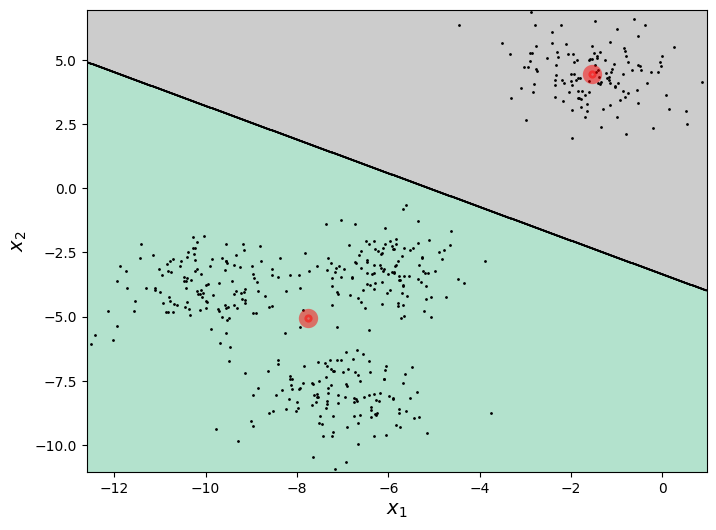

In [25]:
k = 2
kmeans = KMeans(n_clusters=k, n_init=1, random_state=1)
kmeans.fit(x)
print("Iteraciones:", kmeans.n_iter_)

plt.figure(figsize=(8, 6))
plot_decision_boundaries(kmeans, x)
plt.show()

Con algunos datasets, los agrupamientos pueden ser inestables.
Para superar esto, el algoritmo puede ejecutarse con muchas semillas aleatorias diferentes de manera automática. El número de veces que se ejecuta está establecido por el argumento `n_init`. De todas las iteraciones, KMeans se queda con el *mejor* resultado (agrupamiento) final.

Ver: [sklearn.cluster.KMeans.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Acá hay aparentemente cuatro grupos o clusters diferentes, pero cómo podemos definir cuál es el mejor valor de `k` (número de clusters) cuando no sabemos cómo se crearon los datos? O son datos desconocidos para nosotros?

## Inercia y Puntaje de un agrupamiento

Un criterio para definir el *mejor agrupamiento* usa como _métrica_ la **inercia**: que es la distancia media de cada dato a su centroide más cercano (al cuadrado, para que los valores negativos no molesten):

$$
I = \sum_{j=1}^K\sum_{i=1}^{n_j} \left(x_i - \mu_j\right)^2\;\;
$$

La inercia para **todo** el agrupamiento (nuestro resultado final), es la sumatoria de distancias para todos los datos de cada cluster, y para todos los clusters. En la fórmula, la primera suma es sobre la cantidad de clusters $K$ y la segunda es sobre los puntos asignados a cada cluster, donde $\mu_j$ es la posición del centroide del cluster $j$.

In [26]:
kmeans.inertia_

3735.405674929567

Cuanto menor es la inercia, más concentrados están los puntos alrededor de los clusters.

KMeans nos da también un `score` asociado al agrupamiento final. Este es puntaje no es nada más que la inercia cambiada de signo como medida de la performance del algoritmo en este caso (con estos parámetros y con estos datos).

In [27]:
kmeans.score(x)

-3735.405674929567

### Ejercicio

Copien las últimas tres celdas y usen KMeans con un número mayor (o menor) clusters (argumento `n_clusters`). Comparen los valores de inercia para diferentes cantidades de clusters. ¿Se les ocurre para qué puede servir esto?

## Número óptimo de clusters

El algoritmo K-means nos pone en la situación del huevo y la gallina. Para ejecutar K-means necesitamos obligadamente darle el número de clusters (parámetro `k`), pero y si justamente eso es lo que queremos averiguar o saber?

Si no conocemos la estructura de nuestros datos y justamente estamos haciendo un análisis exploratorio donde queremos averiguar `k`? Cómo hacemos?

### Usando inercias

La inercia puede usarse para elegir el número de clusters que mejor describe los datos. Para eso, podemos ver cómo mejor (disminuye) la inercia para diferentes cantidades de clusters:

In [28]:
from sklearn.cluster import KMeans

kmeans_para_varios_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(x)
                        for k in range(1, 10)]
inercias = [model.inertia_ for model in kmeans_para_varios_k]

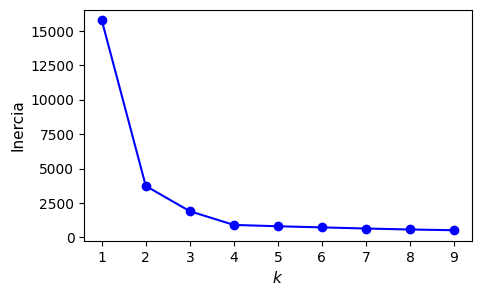

In [29]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, 10), inercias, "bo-")

plt.xlabel("$k$", fontsize=11)
plt.ylabel("Inercia", fontsize=11)

plt.show()

Como tal vez ya habían detectado, la inercia sigue bajando a medida que aumenta el número de clusters. Obviamente, en el límite en que hay tantos clusters como datos, el valor de la inercia será cero.

Pero sí vemos el característico **"codo"**, que muestra un cambio de comportamiento (de pendiente) alrededor de $k=4$. Esto puede indicar que ese es un buen número de clusters. Recuerden que en general, no sabremos cuántos grupos componen _realmente_ el dataset.


Veamos cómo quedan las regiones usando cuatro clusters.

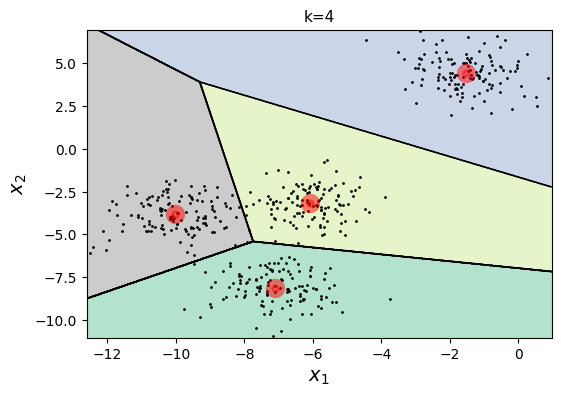

In [30]:
plt.figure(figsize=(6, 4))
plot_decision_boundaries(kmeans_para_varios_k[4-1], x)
plt.title('k=4', fontsize=11)
plt.show()

### Haciendo análisis de Siluetas
Otro enfoque que se puede usar para analizar los agrupamientos y evaluar cuál puede ser el mejor valor de `k`, es el puntaje de *siluetas* de los clusters.

La silueta de un punto o dato es igual a:

$$(b - a)/\max(a, b)$$

donde $a$ es la distancia media a otros datos del mismo cluster (es la distancia media intra-cluster), y $b$ es la distancia media al cluster más cercano, es decir, la distancia media a datos del siguiente cluster más cercano.

El coeficiente de silueta puede variar entre -1 y +1: un coeficiente cercano a +1 significa que el dato está bien asignado dentro de su propio cluster y lejos de otros clusters, mientras que un coeficiente cercano a 0 significa que un dato está cerca del límite de un cluster. Finalmente coeficientes negativos indican que ese dato puede haber sido asignado al cluster equivocado.

Esta métrica de puntuación está implementada en el paquete `metrics` de `sklearn`. Usémosla para encontrar el número óptimo de clusters.

In [31]:
from sklearn.metrics import silhouette_score

silhouette_score(x, kmeans.labels_)

0.7049787496083262

Usémosla igual que antes para encontrar el número óptimo de clusters.

In [32]:
silhouette_scores = [silhouette_score(x, model.labels_)
                     for model in kmeans_para_varios_k[1:]]

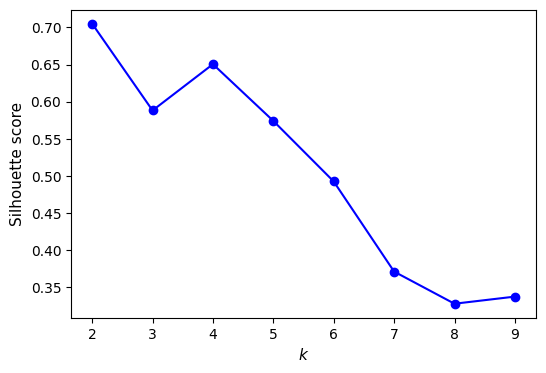

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=11)
plt.ylabel("Silhouette score", fontsize=11)
plt.show()

Para estos datos, cuál es el número óptimo de clusters? Hay uno solo o más?
### Análisis mas detallado de siluetas

En el punto anterior calculamos un único valor de silueta para **todo** un agrupamiento (un agrupamiento es el que se obtiene con un valor de k).

Aunque hayamos evaluado 10 valores diferentes de `k` (de 1 a 10), en todos los casos nos quedamos con un único valor *global* de silueta.

Pero como dijimos más arriba, el valor de silueta se puede calcular para *cada* punto o dato. Veamos cómo es un análisis mas detallado de siluetas. El código se los dejamos a disposición (está oculto):

Código para graficar siluetas


For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.561464362648773
For n_clusters = 6 The average silhouette_score is : 0.4857596147013469


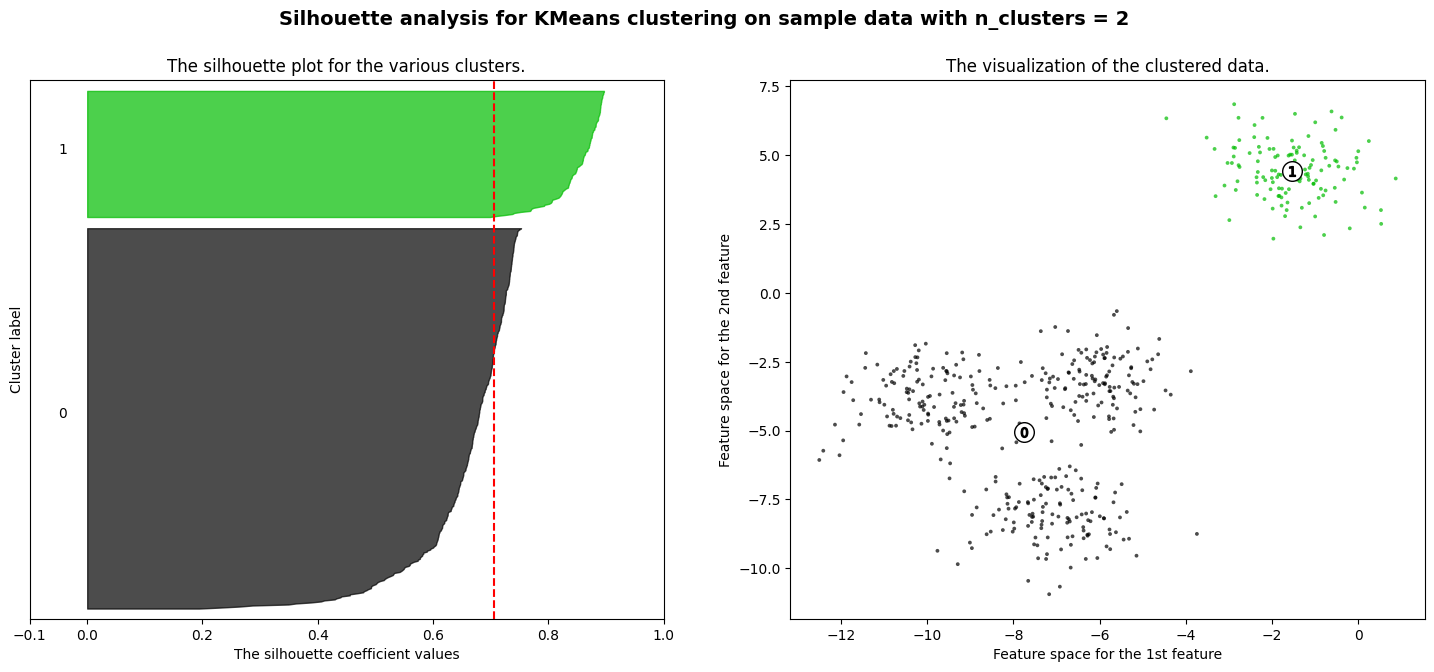

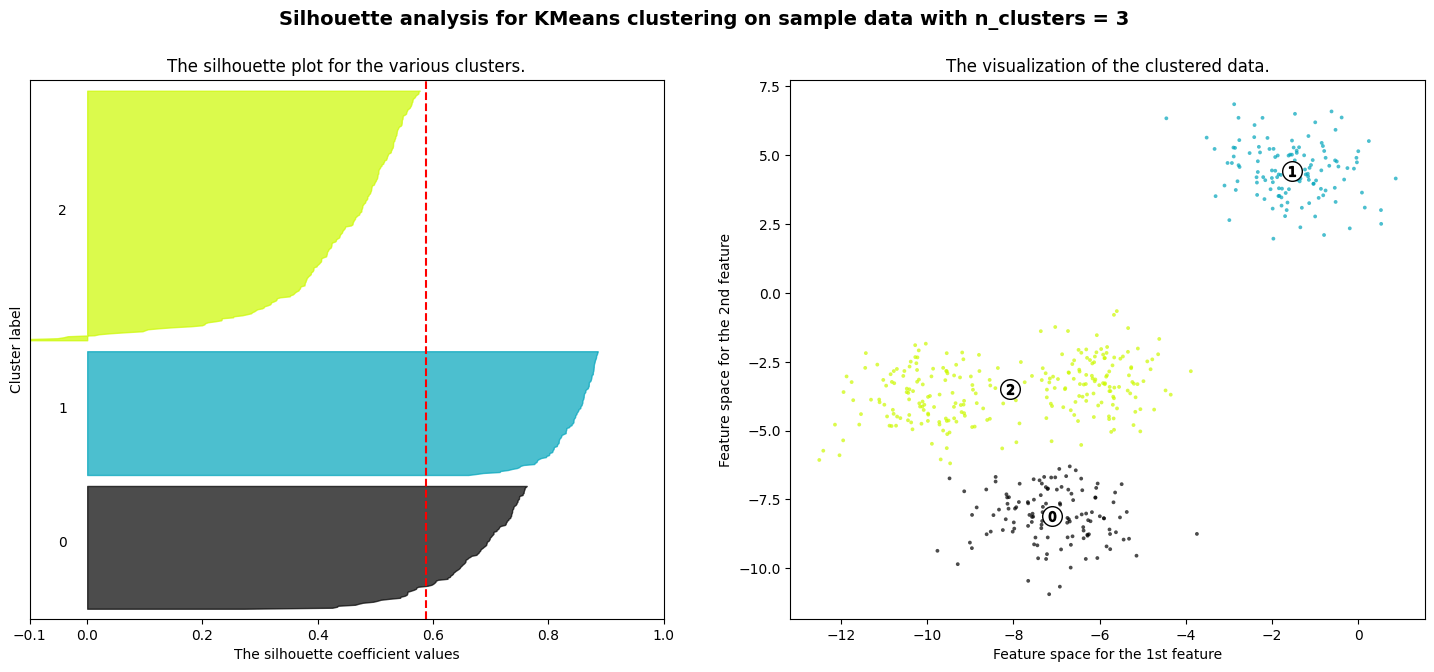

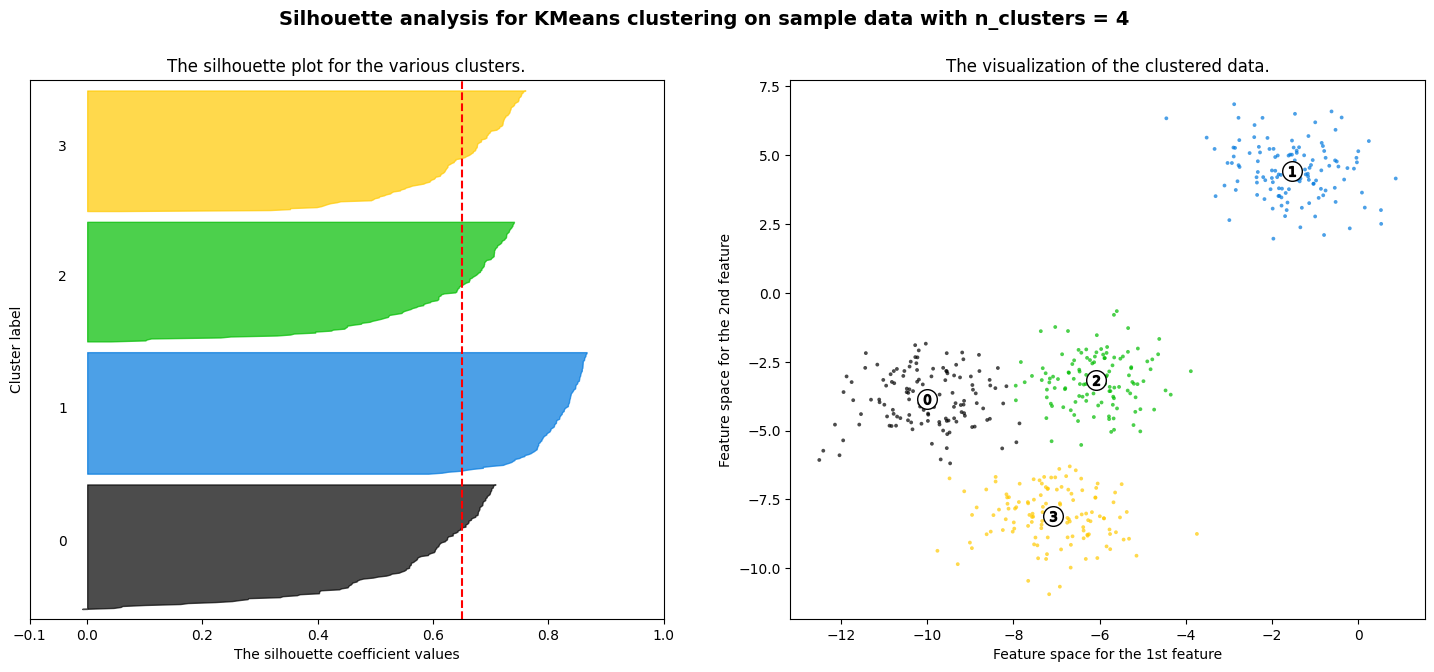

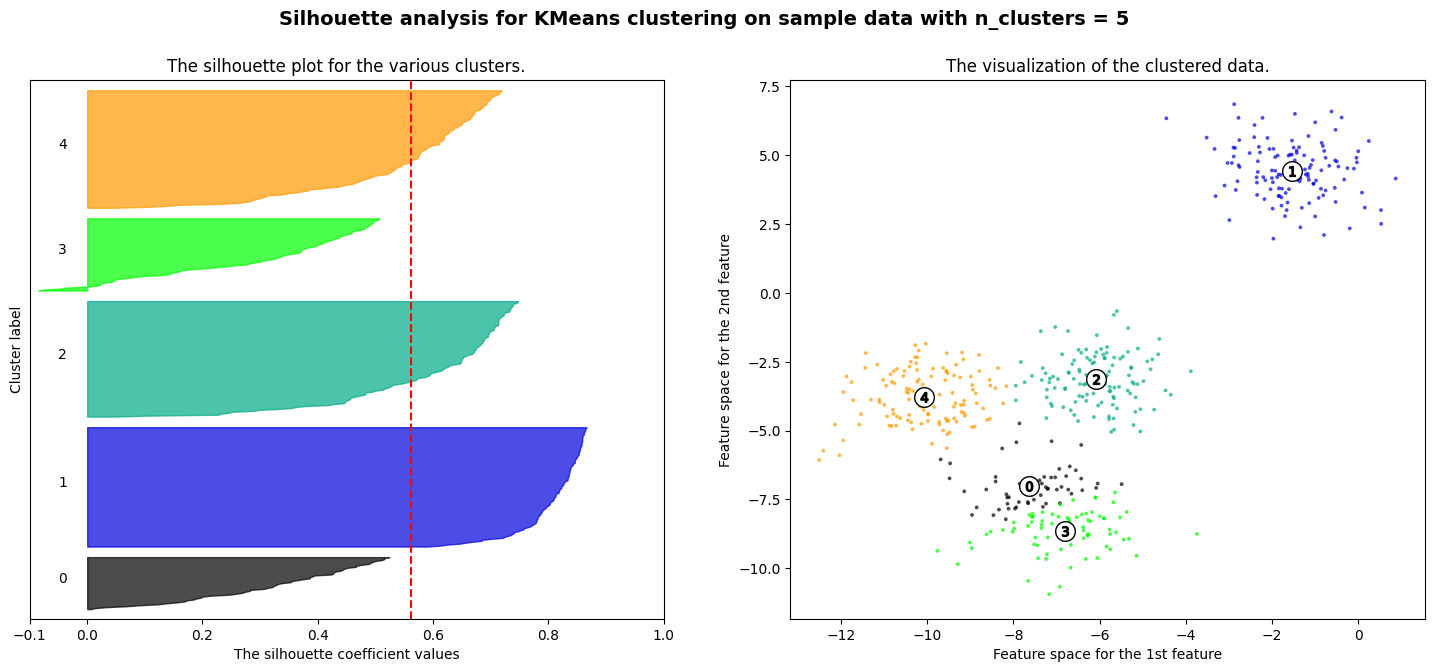

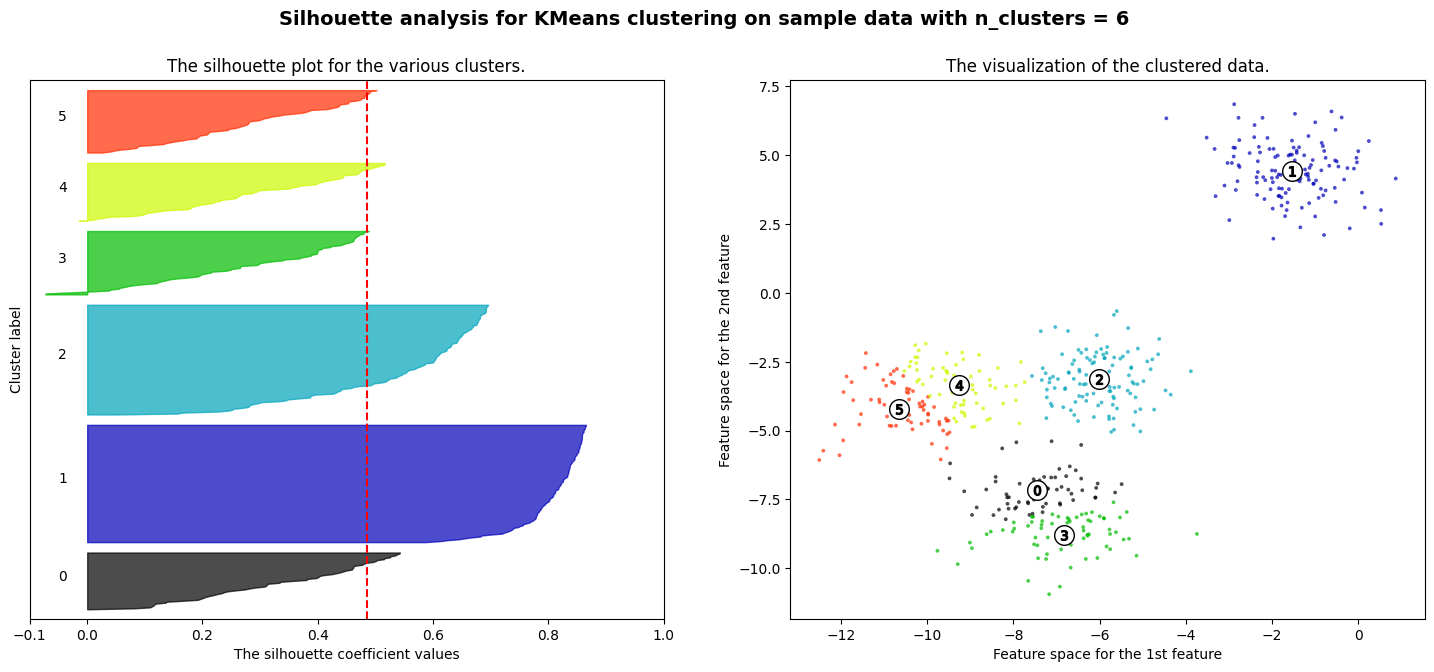

In [34]:
#@title Código para graficar siluetas
# tomado de: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        x[:, 0], x[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

## K-Means para detección de outliers
Una forma en la que K-Means se puede usar para detectar anomalías es entrenando sobre un conjunto de datos limpios (es decir, que no contiene anomalías) y luego evaluando las distancias de datos nuevos, a los centros de los clusters. Si algun dato es una anomalía (un outlier), probablemente su distancia sea grande a todos los centros.

Probemos esto en un ejemplo de juguete. Incluyamos en el conjunto de testeo que separamos arriba un dato atípico.

In [35]:
# vamos a introducir un outlier en los datos
# en esta posicion
i_outlier = 250

assert i_outlier < 500, "i_outlier debe ser menor que 500"
# recordemos que nuestro dataset tenia 500 datos

# Coordenadas del outlier (x,y)
x_outlier = np.array([[-8, 10],])

# y lo escondemos en el conjunto de test
test_outlier = np.vstack((x[:i_outlier], x_outlier, x[i_outlier:]))

In [36]:
x

array([[-6.92324165e+00, -1.06695320e+01],
       [-8.63062033e+00, -7.13940564e+00],
       [-9.63048069e+00, -2.72044935e+00],
       [-2.30647659e+00,  5.30797676e+00],
       [-7.57005366e+00, -3.01446491e+00],
       [-1.00051011e+00,  2.77905153e+00],
       [-4.81826839e+00, -2.77214822e+00],
       [-5.33964799e+00, -1.27625764e+00],
       [-7.94308840e+00, -3.89993901e+00],
       [-5.54924525e+00, -3.41298968e+00],
       [-5.14508990e+00, -9.54492198e+00],
       [-7.09669936e+00, -8.04074036e+00],
       [-5.82641512e+00, -1.96346196e+00],
       [-1.83198811e+00,  3.52863145e+00],
       [-7.34267235e+00, -3.16546482e+00],
       [-7.34072825e+00, -6.92427252e+00],
       [-7.94653906e+00, -3.36768655e+00],
       [-8.24598536e+00, -8.61315821e+00],
       [-1.98197711e+00,  4.02243551e+00],
       [-4.35098035e+00, -3.69476678e+00],
       [-1.04768696e+01, -3.60318139e+00],
       [-1.10195984e+01, -3.15882031e+00],
       [-5.17255904e+00, -4.31835971e+00],
       [-2.

Ahora hacemos un `transform` para calcular las distancias a los clusters.

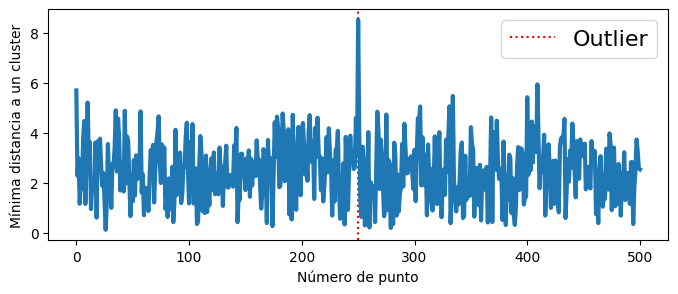

In [37]:
# Calculamos la distancias
distancias = kmeans.transform(test_outlier)

# Calculamos la distancia más chica
min_distancias = np.min(distancias, axis=1)

# Las graficamos en función del número de punto
plt.figure(figsize=(8, 3))
plt.plot(min_distancias, lw=3)
plt.axvline(i_outlier, ls=':', color='r', zorder=-1, label='Outlier')
plt.xlabel('Número de punto')
plt.ylabel('Mínima distancia a un cluster')
plt.legend(loc=0, fontsize=16)

En efecto, vemos que la mayor distancia mínima (sí, eso) se da en la posición del outlier! Con esta técnica podemos identificar los puntos sospechosos y mirarlos con lupa, o pasarlos a un experto del tema.

Pero hay muchos otros picos. ¿Cómo podemos estar seguros de que no se trata de una fluctuación estadística de un dataset limpio? Una opción es mirar antes el gráfico correspondiente al dataset de entrenamiento. Hacemos lo mismo que arriba.

Text(0, 0.5, 'Mínima distancia a un cluster')

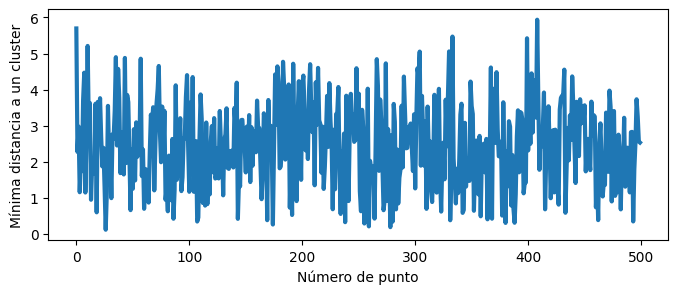

In [38]:
# Calculamos la distancias
distancias_train = kmeans.transform(x)

# Calculamos la distancia más chica
min_distancias_train = np.min(distancias_train, axis=1)

# Las graficamos en función del número de punto
plt.figure(figsize=(8, 3))
plt.plot(min_distancias_train, lw=3)
plt.xlabel('Número de punto')
plt.ylabel('Mínima distancia a un cluster')

Vemos que ninguno de los puntos del conjunto de datos original tienen un efecto pico tan alto (ese punto que llega a 5 es sospechoso?)

Pero esto es esperable, no? Los datos originales son los que se usaron para encontrar los clusters, entonces es de esperar que los puntos estén más cerca de los centros de los clusters. Mmmm, ¿entonces?

Necesitaríamos otro conjunto de datos?

Vamos a ver con mucho más detalle de qué se trata ese otro conjunto de datos en las próximas clases.

Acá brevemente les dejamos picando la idea: dividir nuestros datos originales en dos: 1) un conjunto de datos para hacer agrupamientos (train), encontrar el mejor `k`, etc; y 2) un conjunto de datos para validar lo que hicimos (test).

In [39]:
from sklearn.model_selection import train_test_split

# dividimos x en dos: 80% train, 20% test
x_train, x_test = train_test_split(x, test_size=0.2)

# con esto pueden correr todo el mismo código del notebook
# donde el código usa la variable x que tiene los datos
# pueden reemplazar y usar x_train o x_test

In [40]:
x_train.shape
x_test.shape

(100, 2)

## Otros algoritmos de Clustering.
Hay muchos métodos para hacer clustering. K-Means es uno de los más populares, pero hay muchos otros.

Les proponemos que prueben otros algoritmos en los conjuntos de datos presentados en este notebook.

Otros algoritmos de **clustering** implementados en sklearn [Ver: sklearn.clustering.](https://scikit-learn.org/stable/modules/clustering.html)

![Comparación de algoritmos](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)


# Ejercicio

 1. Vuelvan al principio del notebook (`make_blobs`) y cambien la cantidad de datos (`n_samples`), cantidad de clusters (`centers`), y/o dispersión (`cluster_std`) de los clusters de datos que generamos.
 2. Repitan todo el proceso.
 3. Analicen si las conclusiones sobre el número de clusters que se obtienen con la silueta y la inercia condicen con los cambios que hicieron.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN identifica un número de datos (observaciones) a las que llama *centrales* (core) que son los datos que están en regiones de alta densidad. Genera clusters por etiquetado de otros datos al expandirse desde estas regiones de alta densidad. Este método es bueno para datos que contienen cúmulos de densidades similares.

**Referencias:**
 - [Wikipedia](https://es.wikipedia.org/wiki/DBSCAN)
 - [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
 - [sklearn.clustering](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

In [41]:
# generamos 3 clusters con datos sintéticos

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
x, y = make_blobs(
    n_samples=750,
    centers=centers,
    cluster_std=0.4,
    random_state=0
)

x = StandardScaler().fit_transform(x)

In [42]:
y

array([0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 1, 0, 2, 0, 0, 2, 2, 1, 1, 1,
       1, 1, 0, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 2,
       1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2,
       2, 2, 0, 1, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 1, 0, 2, 1, 1, 2,
       2, 2, 0, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 1,
       1, 2, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1,
       1, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 1, 1, 1, 2,
       2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1,
       2, 2, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1,
       1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2,
       2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0,

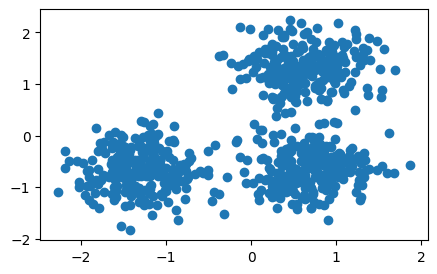

In [43]:
# veamos los datos
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.scatter(x[:, 0], x[:, 1])

Corramos DBSCAN. Los parámetros más importantes de este algoritmo son: `eps` (epsilon) que es la distancia a la que tienen que estar dos datos para ser considerados *vecinos*; y `min_samples` que es el número mínimo de datos que tiene que tener una *vecindad* de datos para que un punto de esa vecindad sea considerado un dato *central* (core).

En conjunto `eps` y `min_samples` ayudan a definir los datos que van a participar en la estimación de *densidad*, que es el concepto clave en este método de clustering.

Un cluster es un conjunto de datos *core* que se construye iterativamente:
 - tomar un dato *central*
 - encontrar todos los vecinos que también son *centrales*
 - encontrar todos los vecinos de los vecinos que también son *centrales*
 - y asi sucesivamente ...

 Un cluster también puede contener datos *no-centrales* (estos son datos que son vecinos de un dato central, pero que no llegan a tener al menos `min_samples` vecinos). Estos son los que suelen estar en los bordes del cluster.

 Finalmente, los outliers son datos que están a una distancia de al menos `eps` de un dato central.

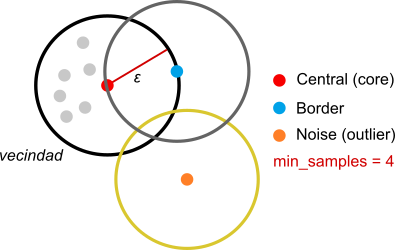

In [60]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

db = DBSCAN(eps=1, min_samples=10).fit(x_scaled)
clusters = db.labels_

# veamos los clusters
print(clusters)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Hay algo raro? Cuántos clusters hay?

In [61]:
# Número de clusters y puntos ruidosos
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f"Numero de clusters: {n_clusters_}")
print(f"Número de outliers (datos ruidosos): {n_noise_}")

Numero de clusters: 1
Número de outliers (datos ruidosos): 0


Codigo para graficar core vs noise y densidad



Text(0.5, 1.0, 'Estimated number of clusters: 1')

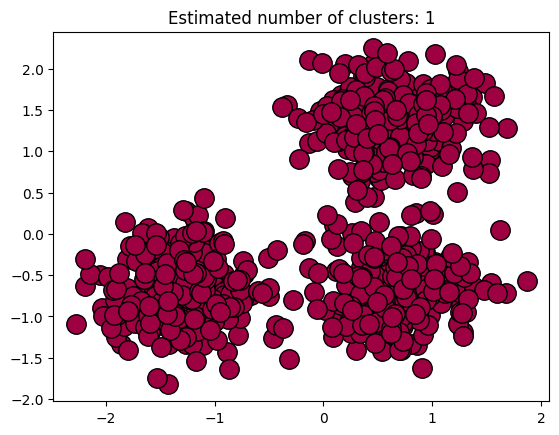

In [62]:
#@title Codigo para graficar core vs noise y densidad
# adaptado de https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

import matplotlib.cm as cm
unique_labels = set(clusters)
core_samples_mask = np.zeros_like(clusters, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = clusters == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")

In [63]:
# Calcular el puntaje de silueta si hay más de 1 cluster válido
if n_clusters_ < 2:
    print("No hay suficientes clusters válidos para calcular la silueta.")
else:
    # Excluir puntos ruidosos (-1) para calcular la silueta
    valid_points = x_scaled[clusters != -1]
    valid_clusters = clusters[clusters != -1]

    if len(np.unique(valid_clusters)) > 1:
        score_silueta = metrics.silhouette_score(valid_points, valid_clusters)
        print(f"Puntaje de Silueta (sin ruido): {score_silueta}")
    else:
        print("No hay suficientes clusters válidos después de excluir el ruido.")

No hay suficientes clusters válidos para calcular la silueta.


### Ejercicio

Cómo encontrar el mejor valor de `eps`? Evaluar distintos valores de este parámetro y graficar el score de silueta en cada caso.

In [58]:
import numpy as np
valores_epsilon = np.arange(0.1, 1.1, 0.01)

dbscan_para_varios_eps = [DBSCAN(eps=i, min_samples=10).fit(x)
                           for i in valores_epsilon]

In [64]:
valores_epsilon

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
       0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08,
       1.09])

In [65]:
dbscan_para_varios_eps[2].eps

0.12

In [66]:
import numpy as np

# array numpy vacio para guardar dos valores
# eps, score_silueta
scores_siluetas = np.empty((0,2))

for dbscan in dbscan_para_varios_eps:
  clusters = dbscan.labels_ # numero de clusters
  eps = dbscan.eps          # valor eps

  # si hay 1 solo cluster al final == no hubo clustering!
  if len(set(clusters)) != 1:
    nueva_fila = [eps, metrics.silhouette_score(x, clusters)]
    scores_siluetas = np.vstack((scores_siluetas, nueva_fila))

print(scores_siluetas)

[[ 0.1        -0.36585257]
 [ 0.11       -0.28064905]
 [ 0.12       -0.03928416]
 [ 0.13        0.11358473]
 [ 0.14        0.03721531]
 [ 0.15        0.24989312]
 [ 0.16        0.42105453]
 [ 0.17        0.44449774]
 [ 0.18        0.48527757]
 [ 0.19        0.5128155 ]
 [ 0.2         0.54261224]
 [ 0.21        0.44923803]
 [ 0.22        0.45524221]
 [ 0.23        0.58254585]
 [ 0.24        0.59077851]
 [ 0.25        0.60184673]
 [ 0.26        0.60644885]
 [ 0.27        0.60676527]
 [ 0.28        0.61312097]
 [ 0.29        0.62048354]
 [ 0.3         0.62552476]
 [ 0.31        0.62569188]
 [ 0.32        0.40317731]
 [ 0.33        0.40381409]
 [ 0.34        0.39684452]
 [ 0.35        0.42107298]
 [ 0.36        0.17676236]
 [ 0.37        0.16020921]
 [ 0.38        0.13739856]
 [ 0.39        0.06109476]
 [ 0.4         0.06109476]
 [ 0.41        0.06109476]
 [ 0.42        0.06109476]
 [ 0.43        0.02342832]
 [ 0.44        0.02342832]
 [ 0.45        0.02342832]
 [ 0.46        0.02342832]
 

Text(0, 0.5, 'Silhouette score')

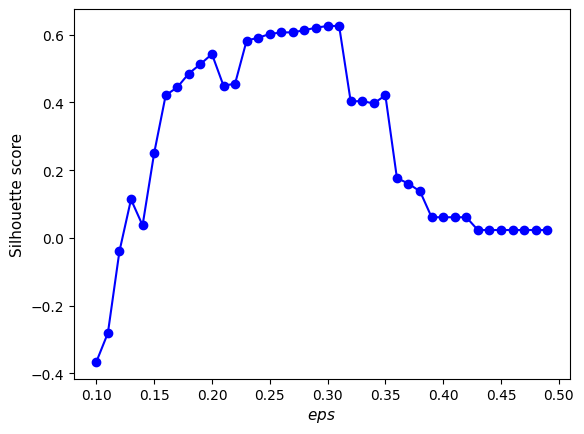

In [67]:
import matplotlib.pyplot as plt

plt.plot(scores_siluetas[:,0], scores_siluetas[:,1], "bo-")
plt.xlabel("$eps$", fontsize=11)
plt.ylabel("Silhouette score", fontsize=11)

### Metricas para evaluar clustering

Sklearn nos da varias métricas adicionales para evaluar clustering: homogeneidad, completitud, etc.

En estos casos, necesitamos dos conjuntos de datos de *etiquetas* o clustering de datos: 1) el clustering o etiquetado **verdadero** y 2) el clustering o etiquetado obtenido por algún método (kmeans, dbscan, etc).

El clustering o etiquetado **verdadero** implica conocer de antemano la clasificación o estructura de los datos, por lo que en este caso el

Referencias:
 - [homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html)
 - [completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html)
 - [v-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html)
 - [rand-index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

Recordemos que en este notebook, somos nosotros los que estamos generando datos sintéticos, y por lo tanto *sabemos* cual es el número verdadero de clusters. De hecho `make_blobs` nos genera el etiquetado **verdadero** en nuestra variable `y`.

Asi que podemos contrastar los valores **verdaderos** de asignación de clusters en `y` con los que obtuvimos con ej. DBSCAN.

In [68]:
# y = clusters (etiquetas) verdaderas, obtenidas de make_blobs
# clusters = db.labels_ obtenidas de dbscan
print(f"Homogeneidad: {metrics.homogeneity_score(y, clusters):.3f}")
print(f"Completitud: {metrics.completeness_score(y, clusters):.3f}")
print(f"V-score: {metrics.v_measure_score(y, clusters):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y, clusters):.3f}")
print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(y, clusters):.3f}")
#print(f"Silhouette Coefficient: {metrics.silhouette_score(x, clusters):.3f}")

Homogeneidad: 0.000
Completitud: 1.000
V-score: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


En situaciones con datos reales (no sintéticos), uno puede contar con un dataset de entrenamiento o un dataset curado por algún experto, donde uno conoce las etiquetas.

Este etiquetado se puede usar para contrastar con el obtenido por algun metodo (ej para ajustar parámetros de clustering).